## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from datetime import datetime

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
import pandas as pd

import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load

In [2]:
# Load the dataset
print("Loading Mars dataset...")
data = np.load("/kaggle/input/mars-training-set/mars_for_students.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
X_test = data["test_set"]

# Add a channel
X_train_val = X_train[..., np.newaxis]
y_train_val = y_train[..., np.newaxis]
X_test = X_test[..., np.newaxis] 
X_test = X_test / 255.0

print("Dataset loaded!")

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train_val))

print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {num_classes}")

print(f"\nShape of X_train: {X_train_val.shape}")
print(f"Shape of y_train: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

Loading Mars dataset...
Dataset loaded!

Input shape: (64, 128)
Number of classes: 5

Shape of X_train: (2615, 64, 128, 1)
Shape of y_train: (2615, 64, 128, 1)
Shape of X_test: (10022, 64, 128, 1)


## 👽 Detect Outliers

In [3]:
def apply_colormap(label, colormap):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

# Define the colormap manually
colormap = np.array([
    [0, 0, 0],        # black for background
    [139, 69, 19],    # brown for soil
    [80, 80, 80],  # gray for bedrock
    [244, 164, 96],   # sandy brown for sand
    [105, 105, 105]   # dark gray for big rock
]) / 255.0  # Normalize to [0, 1] range for matplotlib

In [4]:
# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
def calculate_hash(y_train_val):
    hash_dict = defaultdict(list)
    for idx, image in enumerate(y_train_val):
        img_hash = calculate_image_hash(image)
        hash_dict[img_hash].append(idx)
    return hash_dict

Duplicate images found!


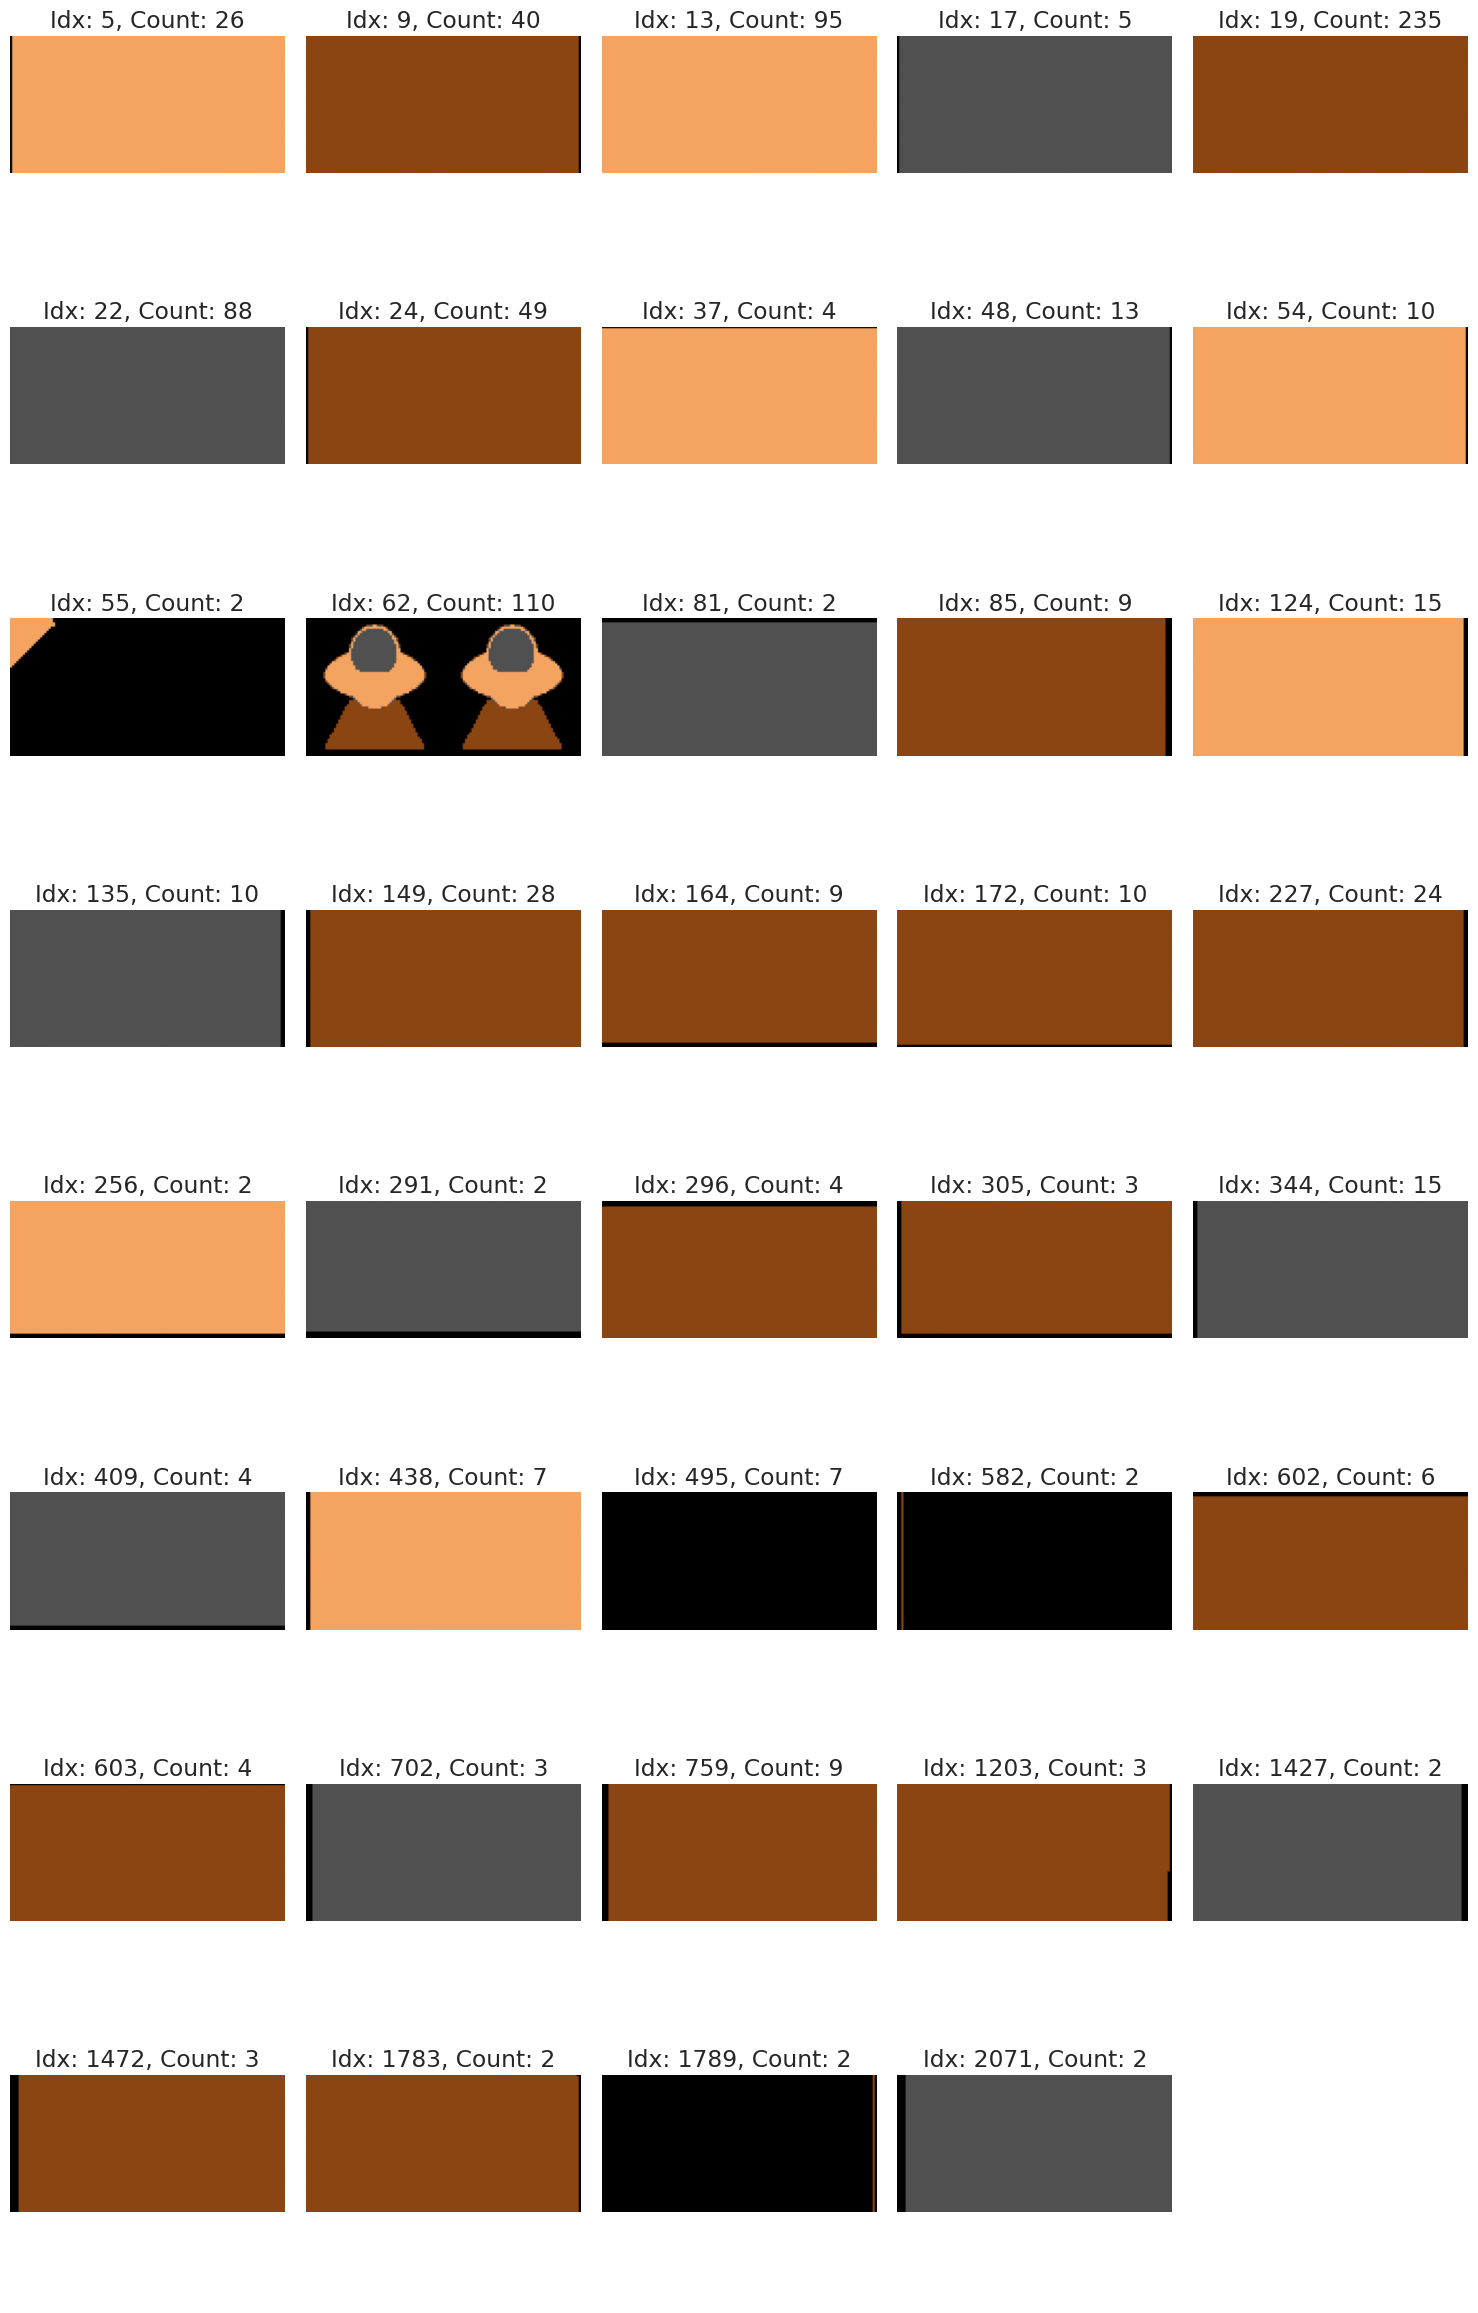

In [5]:
def calculate_duplicates(labels):

    # Find duplicates
    hash_dict = calculate_hash(labels)
    return {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

def plot_duplicates(labels):
    
    duplicates = calculate_duplicates(labels)

    if duplicates:
        print("Duplicate images found!")
   
        num_duplicates = len(duplicates)
        cols = 5 
        rows = (num_duplicates + cols - 1) // cols  
    
        # Create the figure and subplots
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten()

        # Create colormap for labels
        num_classes = len(np.unique(y_train_val))
       # colormap = create_segmentation_colormap(num_classes)

        for i, (img_hash, indices) in enumerate(duplicates.items()):
            # Select one representative image
            representative_idx = indices[0]
            occurrence_count = len(indices)  
            ax = axes[i]

            colored_label = apply_colormap(y_train_val[representative_idx], colormap)
            ax.imshow(colored_label)

            # Set title with hash, occurrences, and first index
            ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
            ax.axis('off')

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()

    else:
        print("No duplicate images found!")   


plot_duplicates(y_train_val)

In [6]:
# Function to get images associated with a specific index
def get_images_by_index(index):
    hash_dict = calculate_hash(y_train_val)
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

In [7]:
alien_index = 62

# Get associated indices
img_hash, alin_associated_indices = get_images_by_index(alien_index)

if(X_train_val.shape[0] == 2615):
    X_train_val = np.delete(X_train_val, alin_associated_indices, axis=0)
    y_train_val = np.delete(y_train_val, alin_associated_indices, axis=0)
    print("Outliers removed")
else:
    print("Outliers already removed")

print("Dataset dimension:", X_train_val.shape)

Outliers removed
Dataset dimension: (2505, 64, 128, 1)


## 🔄 Process Data

In [8]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

In [9]:
# Split the training set into training and validation sets
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

# Display dataset information
print(f"\nNumber of images:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")

Splitting data...
Data splitted!

Number of images:
Training set: 2004
Validation set: 501
Test set: 10022


In [10]:
# Define the category mapping
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4   # big rock
}

# Define the classes 
classes = ['background', 'soil', 'bedrock', 'sand', 'big rock'] 

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of categories: {len(category_map)}")

Number of categories: 5


In [11]:
# Define augmentation
def random_flip_left_right(image, label, seed):
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

def random_flip_up_down(image, label, seed):
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob < 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob < 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    return image, label

def random_rot90(image, label, seed):
    """Random 90-degree rotations."""
    k = tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32) *2
    image = tf.image.rot90(image, k)
    label = tf.image.rot90(label, k)
    return image, label

def random_contrast(image, label, seed):
    flip_prob = tf.random.uniform([], seed=seed)
    contrast_factor = tf.random.uniform([], 2, 2.5)
    image = tf.cond(
        flip_prob < 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    image = tf.image.adjust_contrast(image, contrast_factor)
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    #image = image[0,:,:,:]
    return image, label

def apply_augmentations(image, label):
    seed = np.random.randint(0, 1000000)
    image, label = random_flip_left_right(image, label, seed)
    #image, label = random_flip_up_down(image, label, seed)
    #image, label = random_contrast(image, label, seed)
    return image, label

In [12]:
def preprocess_data(X, y, input_size=(64, 128)):
    X = tf.image.resize(X, input_size)
    X = tf.cast(X, tf.float32) / 255.0
    
    y = tf.image.resize(y, input_size, method='bilinear')
    y = tf.cast(y, tf.int32)
    return X, y

In [13]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset. 
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) #create data from images and masks

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed) #we can shuffle it

    # Preprocess immages and labels
    dataset = dataset.map(
        preprocess_data,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply augmentations if specified
    if augment:
        dataset = dataset.map(
            lambda x, y: apply_augmentations(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # Batch the data (do it now and not at training time)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [14]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False #for validation not necessary to shuffle it
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


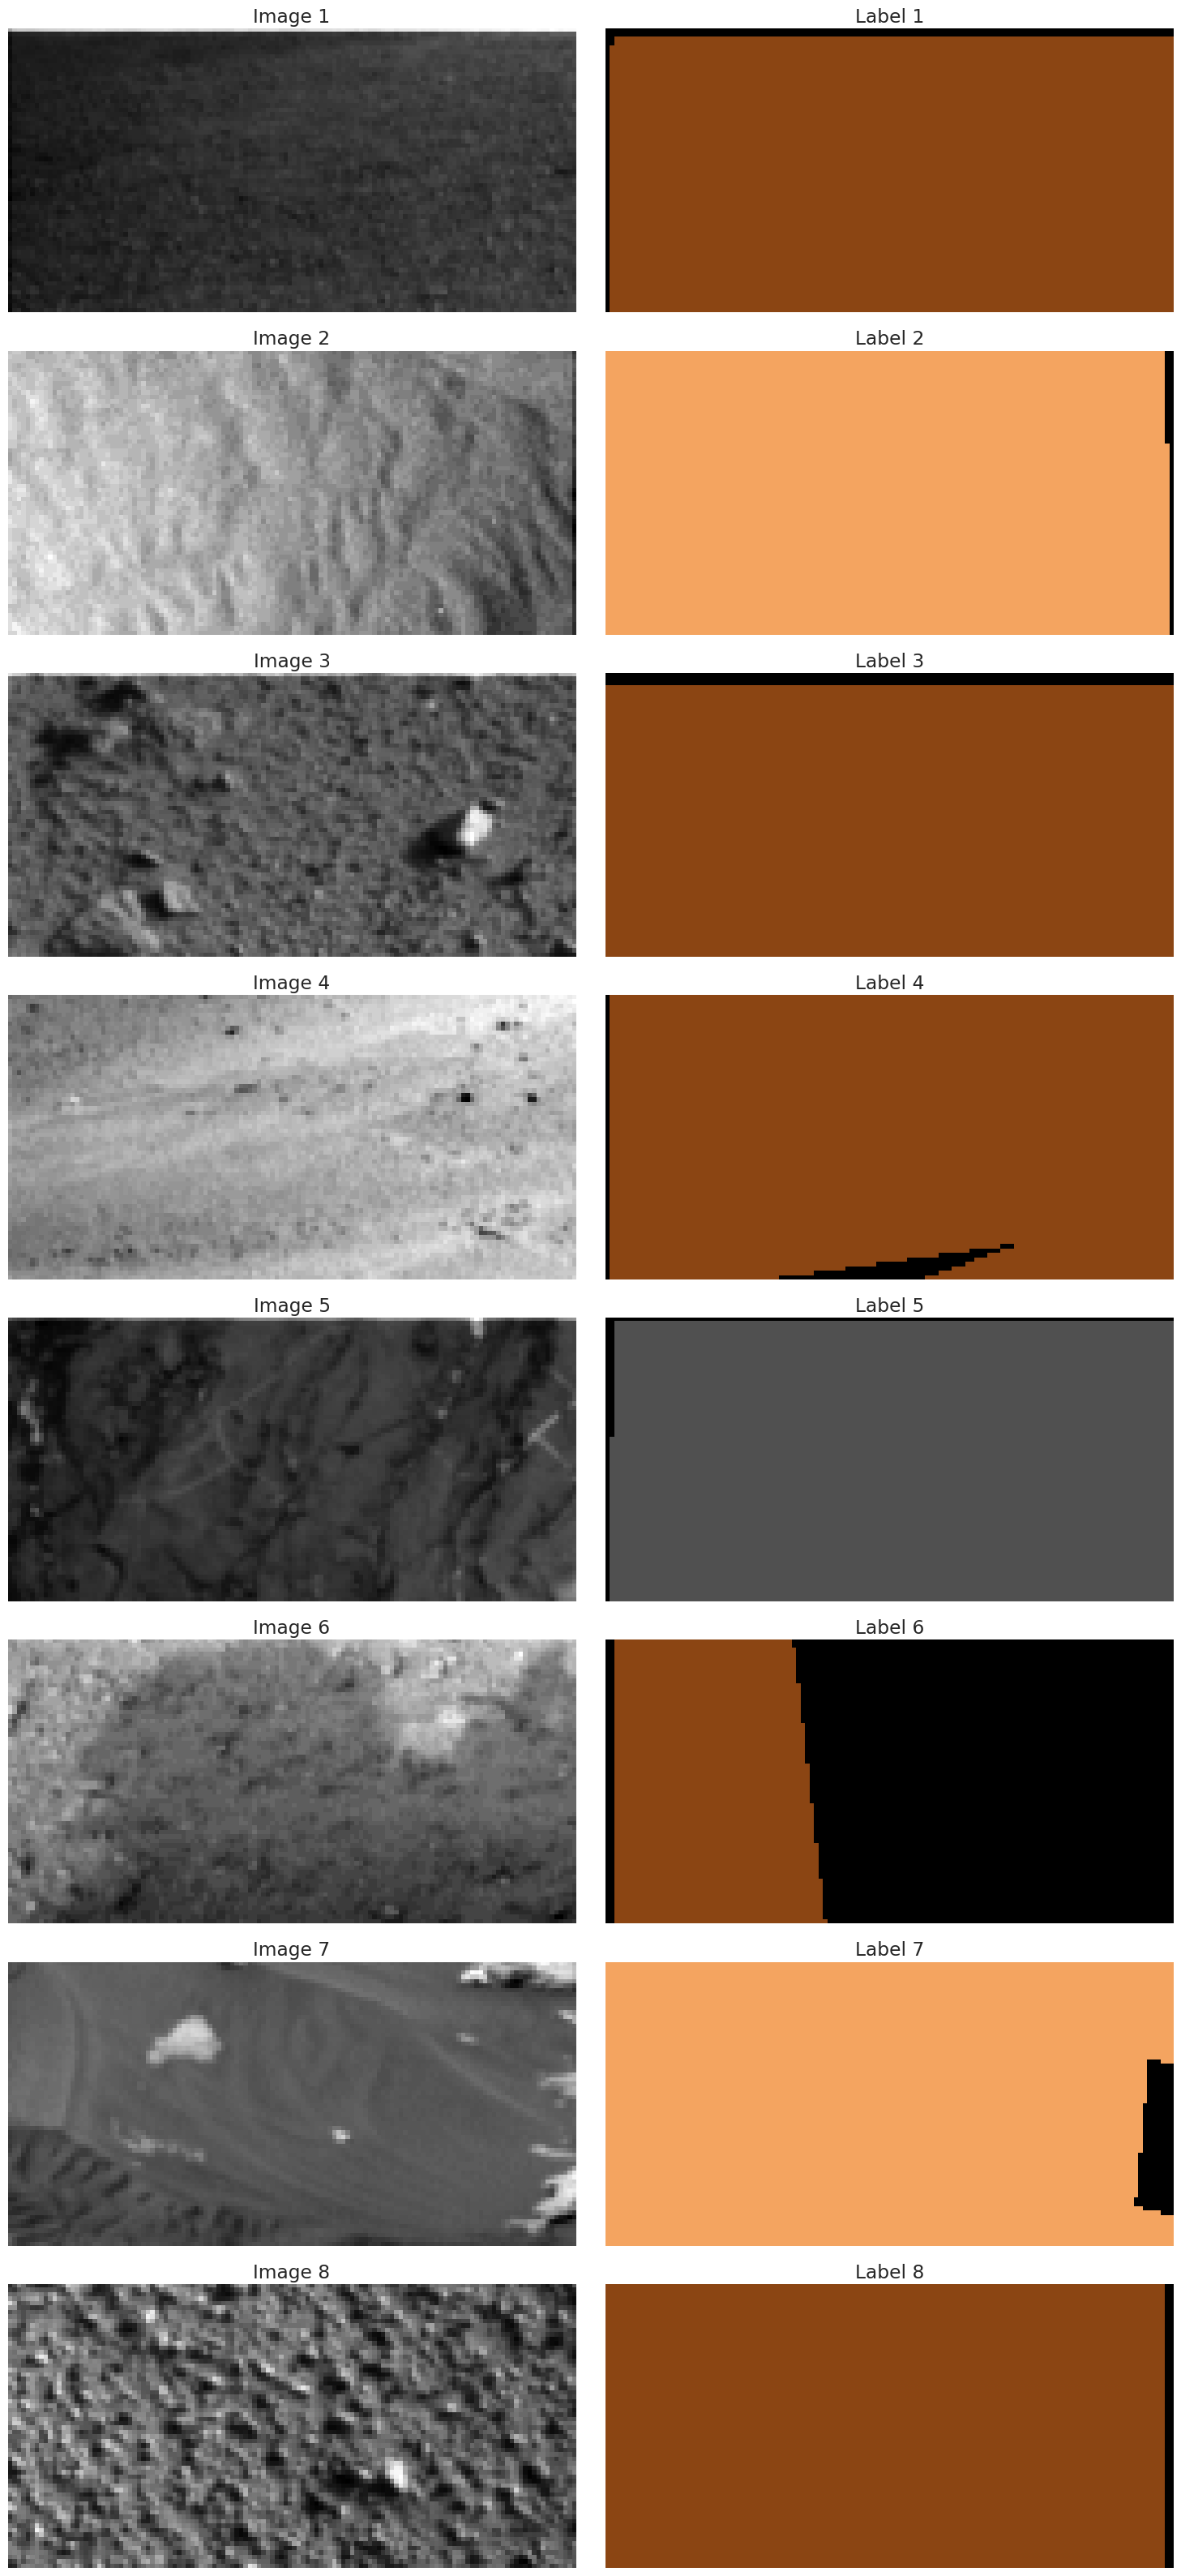

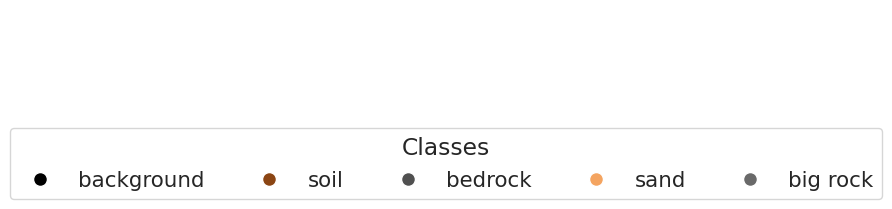

In [15]:
# Plot real image and ground truth (reduced resolution)
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(category_map)  # Ensure colormap covers all classes, including the background

        for j in range(min(num_samples, len(images))):
            # Plot original grayscale image (no colormap)
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images[j], cmap='gray')  # Use 'gray' cmap for the images (ensure grayscale)
            plt.title(f'Image {j + 1}')
            plt.axis('off')

            # Plot colored label (apply colormap only to labels)
            plt.subplot(num_samples, 2, j * 2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)  # Apply colormap to the labels only
            plt.imshow(colored_label)  # Show the colored label
            plt.title(f'Label {j + 1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

    handles = []
    # After all images have been plotted, add the legend once
    for label_idx in category_map:
        color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))
    
    # Create a single legend displayed at the bottom
    fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
    ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
    ax.axis('off')
    plt.show()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=8)

## 🛠️ Model Definition and Training

In [16]:
def squeeze_excite(x, ratio=16, name='SqueezeExcite_'):
    nb_chan = x.shape[-1]

    y = layers.GlobalAveragePooling2D(name=name+'avg'.format(name))(x)
    y = layers.Dense(nb_chan // ratio, activation='relu', name=name +'dense1'.format(name))(y)
    y = layers.Dense(nb_chan, activation='sigmoid', name=name +'dense2'.format(name))(y)

    y = layers.Multiply(name=name+'mul'.format(name))([x, y])
    
    return x

In [17]:
def unet_block(input_tensor, filters, kernel_size=3, dilatation_rate = 1, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = layers.Conv2D(filters, kernel_size=kernel_size, dilation_rate=dilatation_rate, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = layers.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = layers.Activation(activation, name=name + 'activation' + str(i + 1))(x)
    
    x = squeeze_excite(x, name=name+'se')
    
    # Return the transformed tensor
    return x

In [18]:
def aspp_block(input_tensor, filters, name='ASPP_'):
    """Atrous Spatial Pyramid Pooling block."""
    # Branch 1: 1x1 Convolution
    conv_1x1 = layers.Conv2D(filters, kernel_size=1, padding='same', name=name + 'conv_1x1')(input_tensor)
    conv_1x1 = layers.BatchNormalization(name=name + 'bn_1x1')(conv_1x1)
    conv_1x1 = layers.Activation('relu', name=name + 'act_1x1')(conv_1x1)

    # Branch 2: 3x3 Convolution with dilation rate 6
    conv_3x3_d6 = layers.Conv2D(filters, kernel_size=3, dilation_rate=6, padding='same', name=name + 'conv_3x3_d6')(input_tensor)
    conv_3x3_d6 = layers.BatchNormalization(name=name + 'bn_3x3_d6')(conv_3x3_d6)
    conv_3x3_d6 = layers.Activation('relu', name=name + 'act_3x3_d6')(conv_3x3_d6)

    # Branch 3: 3x3 Convolution with dilation rate 12
    conv_3x3_d12 = layers.Conv2D(filters, kernel_size=3, dilation_rate=12, padding='same', name=name + 'conv_3x3_d12')(input_tensor)
    conv_3x3_d12 = layers.BatchNormalization(name=name + 'bn_3x3_d12')(conv_3x3_d12)
    conv_3x3_d12 = layers.Activation('relu', name=name + 'act_3x3_d12')(conv_3x3_d12)
   
    # Branch 4: 3x3 Convolution with dilation rate 18
    conv_3x3_d18 = layers.Conv2D(filters, kernel_size=3, dilation_rate=18, padding='same', name=name + 'conv_3x3_d18')(input_tensor)
    conv_3x3_d18 = layers.BatchNormalization(name=name + 'bn_3x3_d18')(conv_3x3_d18)
    conv_3x3_d18 = layers.Activation('relu', name=name + 'act_3x3_d18')(conv_3x3_d18)

    # Branch 5: Global Average Pooling
    global_avg = layers.GlobalAveragePooling2D(name=name + 'global_avg_pool')(input_tensor)
    global_avg = layers.Reshape((1, 1, -1), name=name + 'reshape')(global_avg)
    global_avg = layers.Conv2D(filters, kernel_size=1, padding='same', name=name + 'conv_global')(global_avg)
    global_avg = layers.BatchNormalization(name=name + 'bn_global')(global_avg)
    global_avg = layers.Activation('relu', name=name + 'act_global')(global_avg)
    global_avg = layers.UpSampling2D(size=input_tensor.shape[1:3], interpolation='bilinear', name=name + 'upsample')(global_avg)

    # Concatenate all branches (conv_3x3_d12, conv_3x3_d18, and global_avg NOT USED)
    concat = layers.Concatenate(name=name + 'concat')([conv_1x1, conv_3x3_d6, conv_3x3_d12])

    # Output projection layer
    output = layers.Conv2D(filters, kernel_size=1, padding='same', name=name + 'conv_out')(concat)
    output = layers.BatchNormalization(name=name + 'bn_out')(output)
    output = layers.Activation('relu', name=name + 'act_out')(output)

    return output

In [19]:
def unet(input_shape, aspp_filters, num_classes, name, seed=seed):
    tf.random.set_seed(seed)
    input_layer = layers.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')  # first block with 32 filters
    d1 = layers.MaxPooling2D()(down_block_1)  # reduce spatial complexity

    down_block_2 = unet_block(d1, 64, name='down_block2_')  # second block with 64 filters
    d2 = layers.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')  # third block with 128 filters
    d3 = layers.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')  # added block with 256 filters
    d4 = layers.MaxPooling2D()(down_block_4)

    # Bottleneck with 512 filters
    bottleneck = aspp_block(d4, aspp_filters, name='bottleneck_')  # bottleneck with 512 filters

    # Upsampling path: increase spatial complexity
    u1 = layers.UpSampling2D()(bottleneck)  # Upsampling layer
    u1 = layers.Concatenate()([u1, down_block_4])  # Skip connection from downsampling path
    u1 = unet_block(u1, 256, name='up_block1_')  # first upsampling block with 256 filters

    u2 = layers.UpSampling2D()(u1)
    u2 = layers.Concatenate()([u2, down_block_3])
    u2 = unet_block(u2, 128, name='up_block2_')  # second upsampling block with 128 filters

    u3 = layers.UpSampling2D()(u2)
    u3 = layers.Concatenate()([u3, down_block_2])
    u3 = unet_block(u3, 64, name='up_block3_')  # third upsampling block with 64 filters

    u4 = layers.UpSampling2D()(u3)
    u4 = layers.Concatenate()([u4, down_block_1])
    u4 = unet_block(u4, 32, name='up_block4_')  # fourth upsampling block with 32 filters

    # Output Layer: final convolution with softmax activation for segmentation
    output_layer = layers.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name=name)
    return model

Model: "Double_Unet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Input             │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ First_Unet        │ (None, 64, 128, │ 7,600,965 │ Input[0][0]    │   Y   │
│ (Functional)      │ 5)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └ input_layer  │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 64, 128, │       320 │ -              │   Y   │
│ down_block1_conv1 │ 32)             │           │                │       │
│ (Conv2D)          │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 64, 128, │       128 │ -              │   Y   │
│ down_block1_bn1   │ 32)             │           │                │       │
│ (BatchNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 64, 128, │         0 │ -              │   -   │
│ down_block1_acti… │ 32)             │           │                │       │
│ (Activation)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 64, 128, │     9,248 │ -              │   Y   │
│ down_block1_conv2 │ 32)             │           │                │       │
│ (Conv2D)          │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 64, 128, │       128 │ -              │   Y   │
│ down_block1_bn2   │ 32)             │           │                │       │
│ (BatchNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 64, 128, │         0 │ -              │   -   │
│ down_block1_acti… │ 32)             │           │                │       │
│ (Activation)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 32, 64,  │         0 │ -              │   -   │
│ max_pooling2d     │ 32)             │           │                │       │
│ (MaxPooling2D)    │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 32, 64,  │    18,496 │ -              │   Y   │
│ down_block2_conv1 │ 64)             │           │                │       │
│ (Conv2D)          │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 32, 64,  │       256 │ -              │   Y   │
│ down_block2_bn1   │ 64)             │           │                │       │
│ (BatchNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 32, 64,  │         0 │ -              │   -   │
│ down_block2_acti… │ 64)             │           │                │       │
│ (Activation)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼─────

 Total params: 12,773,185 (48.73 MB)

 Trainable params: 12,759,361 (48.67 MB)

 Non-trainable params: 13,824 (54.00 KB)

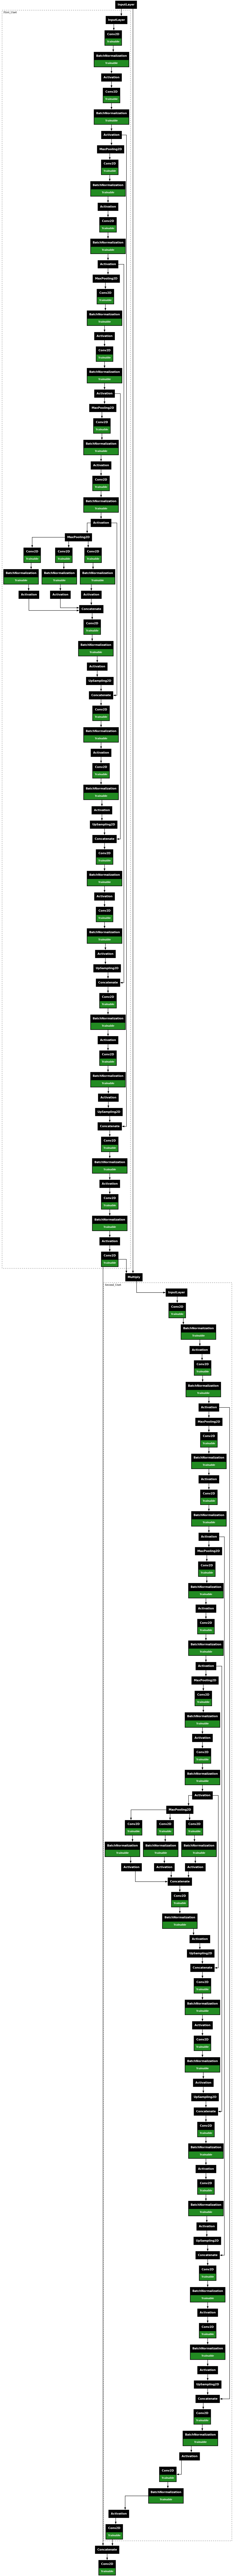

In [20]:
# Define the Double U-Net 
def double_unet(input_shape, num_classes):
    inputs = layers.Input(input_shape, name="Input")

    # First U-Net (with name 'First_Unet')
    first_unet = unet(input_shape, 512, num_classes, name="First_Unet")
    first_output = first_unet(inputs)

    #first_output_resized = layers.Conv2D(1, kernel_size=1, padding='same', activation="relu", name='output_layer_resized')(first_output)

    # Skip connection from input to second U-Net (make sure they match in shape)
    skip_connection = inputs
    
    # Multiply the output of the first U-Net (1 channel) with the input (skip connection)
    refined_input = layers.Multiply()([first_output, skip_connection])

    # Second U-Net (with name 'Second_Unet')
    second_unet = unet((64,128,5), 256, num_classes, name="Second_Unet")
    second_output = second_unet(refined_input)
    
    # Concatenate the output of the first U-Net with the output of the second U-Net
    final_output = layers.Concatenate()([first_output, second_output])

    # Output Layer: final convolution with softmax activation for segmentation
    final_output = layers.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(final_output)
    
    # Final model with concatenated outputs
    model = models.Model(inputs, final_output, name="Double_Unet")
    
    return model

# Input shape
input_shape = (64, 128, 1)
num_classes = 5

# Build the Double U-Net model
model = double_unet(input_shape, num_classes)

# Print a detailed summary of the model with expanded nested layers and trainable parameters
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [21]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback: plot during the training the prediction and the images
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=5):
        super().__init__()
        self.val_dataset = val_dataset  # The validation dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get a batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                image = image_batch[3]  # Take the first image from the batch
                label = label_batch[3]  # Take the first label from the batch

                # Add batch dimension to the image (if necessary)
                image = tf.expand_dims(image, 0)

                # Perform prediction
                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()  # Convert to NumPy array for visualization

                # Create colormap (assuming a predefined function `create_segmentation_colormap`)
                num_classes = NUM_CLASSES
               # colormap = create_segmentation_colormap(num_classes)

                # Plot the results
                plt.figure(figsize=(16, 4))

                # Input image
                plt.subplot(1, 3, 1)
                plt.imshow(image[0], cmap='gray')
                plt.title("Input Image")
                plt.axis('off')

                # Ground truth
                plt.subplot(1, 3, 2)
                colored_label = apply_colormap(label.numpy(), colormap)  # Assuming `apply_colormap` is defined
                plt.imshow(colored_label)
                plt.title("Ground Truth Mask")
                plt.axis('off')

                # Prediction
                plt.subplot(1, 3, 3)
                colored_pred = apply_colormap(y_pred[0], colormap)  # Apply colormap to prediction
                plt.imshow(colored_pred)
                plt.title("Predicted Mask")
                plt.axis('off')

                plt.tight_layout()
                plt.show()
                plt.close()

In [22]:
# Flatten the labels to compute class weights
y_train_flat = y_train.flatten()

# Calculate weights
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train_flat), 
    y=y_train_flat
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

Class weights: {0: 0.8249853953360052, 1: 0.5935027933021484, 2: 0.8366099618482732, 3: 1.1096943312319119, 4: 153.93846875146514}


In [23]:
def sparse_weighted_loss(y_true, y_pred, class_weights):
    """
    Weighted sparse categorical cross-entropy.
    """
    # Convert y_true to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(class_weights))
    
    # Calculate weights for each sample
    weights = tf.reduce_sum(y_true_one_hot * tf.constant(class_weights, dtype=tf.float32), axis=-1)
    
    # Compute sparse categorical crossentropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    weights = tf.squeeze(weights, axis=-1)
    
    # Apply weights to the loss
    return tf.reduce_mean(loss * weights)

In [24]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=lambda y_true, y_pred: sparse_weighted_loss(y_true, y_pred, class_weights),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [25]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

learning_rate = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',
    mode='max', 
    factor=0.1, 
    patience=15, 
    min_lr=1e-5
)

viz_callback = VizCallback(val_dataset, frequency=5)

Epoch 1/1000


I0000 00:00:1733524628.326125      75 service.cc:145] XLA service 0x7c34a4005690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733524628.326201      75 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733524628.326209      75 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733524635.496055      75 assert_op.cc:38] Ignoring Assert operator compile_loss/lambda/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1733524686.832308      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.1500 - loss: 1.5610 - mean_iou: 0.0922

W0000 00:00:1733524701.921733      74 assert_op.cc:38] Ignoring Assert operator compile_loss/lambda/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1519 - loss: 1.5606 - mean_iou: 0.0935   

W0000 00:00:1733524740.250651      73 assert_op.cc:38] Ignoring Assert operator compile_loss/lambda/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733524747.119776      74 assert_op.cc:38] Ignoring Assert operator compile_loss/lambda/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


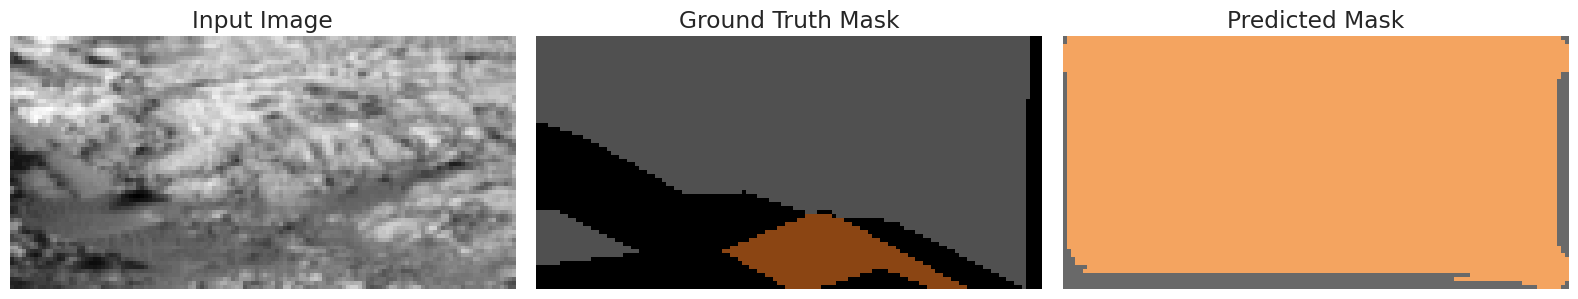

32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.1537 - loss: 1.5601 - mean_iou: 0.0947 - val_accuracy: 0.1850 - val_loss: 1.7785 - val_mean_iou: 0.0650 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.2984 - loss: 1.5145 - mean_iou: 0.1805 - val_accuracy: 0.0860 - val_loss: 1.6895 - val_mean_iou: 0.0599 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 430ms/step - accuracy: 0.3284 - loss: 1.4450 - mean_iou: 0.1802 - val_accuracy: 0.1966 - val_loss: 1.6489 - val_mean_iou: 0.0658 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.3423 - loss: 1.4121 - mean_iou: 0.1869 - val_accuracy: 0.1979 - val_loss: 1.7200 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.3822 - loss: 1.3790 - mean_iou: 0.2163 - val_accuracy: 0.1956 - val_loss: 1.7280 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 6/1000
32/32 ━━━━━━━━━━━

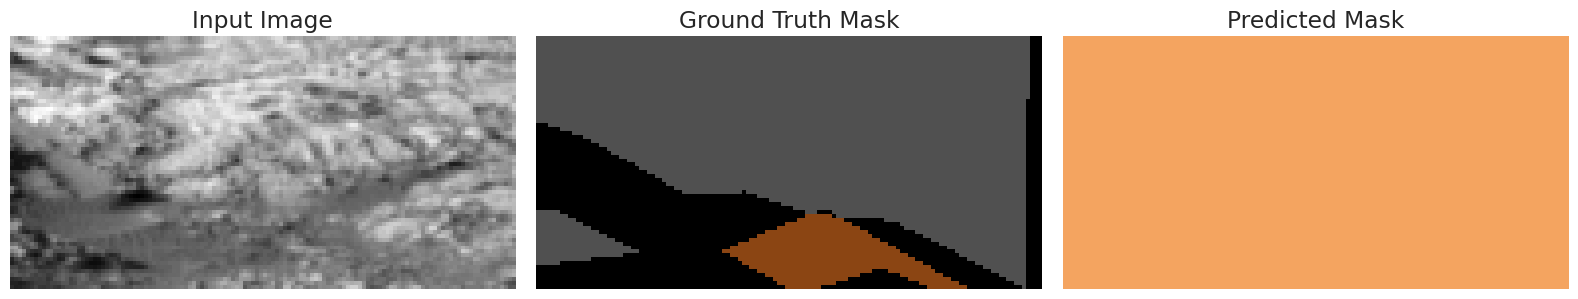

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.4343 - loss: 1.3731 - mean_iou: 0.2422 - val_accuracy: 0.1979 - val_loss: 1.7154 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 416ms/step - accuracy: 0.4218 - loss: 1.3282 - mean_iou: 0.2439 - val_accuracy: 0.1979 - val_loss: 1.7704 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.4075 - loss: 1.3076 - mean_iou: 0.2485 - val_accuracy: 0.1530 - val_loss: 1.7597 - val_mean_iou: 0.0494 - learning_rate: 0.0010
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.4725 - loss: 1.2954 - mean_iou: 0.2728 - val_accuracy: 0.0682 - val_loss: 1.7062 - val_mean_iou: 0.0367 - learning_rate: 0.0010
Epoch 10/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.4287 - loss: 1.2854 - mean_iou: 0.2514 - val_accuracy: 0.1979 - val_loss: 1.8779 - val_mean_iou: 0.0525 - learning_rate: 0.0010
Epoch 11/1000
32/32 ━━━━━━━

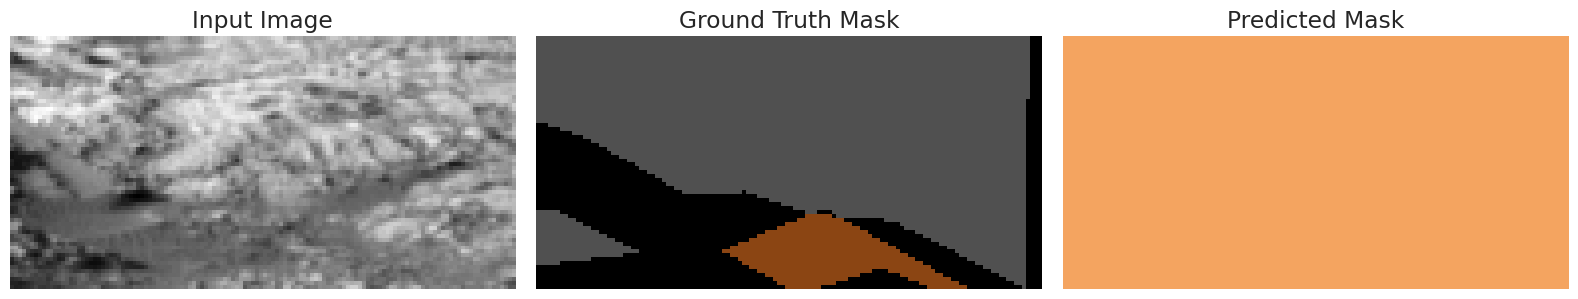

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.3977 - loss: 1.3358 - mean_iou: 0.2435 - val_accuracy: 0.1979 - val_loss: 2.0050 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 12/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.4508 - loss: 1.2414 - mean_iou: 0.2784 - val_accuracy: 0.1979 - val_loss: 1.9672 - val_mean_iou: 0.0525 - learning_rate: 0.0010
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.4974 - loss: 1.1713 - mean_iou: 0.3190 - val_accuracy: 0.1979 - val_loss: 2.0478 - val_mean_iou: 0.0525 - learning_rate: 0.0010
Epoch 14/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.5197 - loss: 1.1882 - mean_iou: 0.3290 - val_accuracy: 0.2271 - val_loss: 2.0127 - val_mean_iou: 0.0721 - learning_rate: 0.0010
Epoch 15/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.5073 - loss: 1.2003 - mean_iou: 0.3147 - val_accuracy: 0.2685 - val_loss: 1.8344 - val_mean_iou: 0.0986 - learning_rate: 0.0010
Epoch 16/1000
32/32 ━━━━

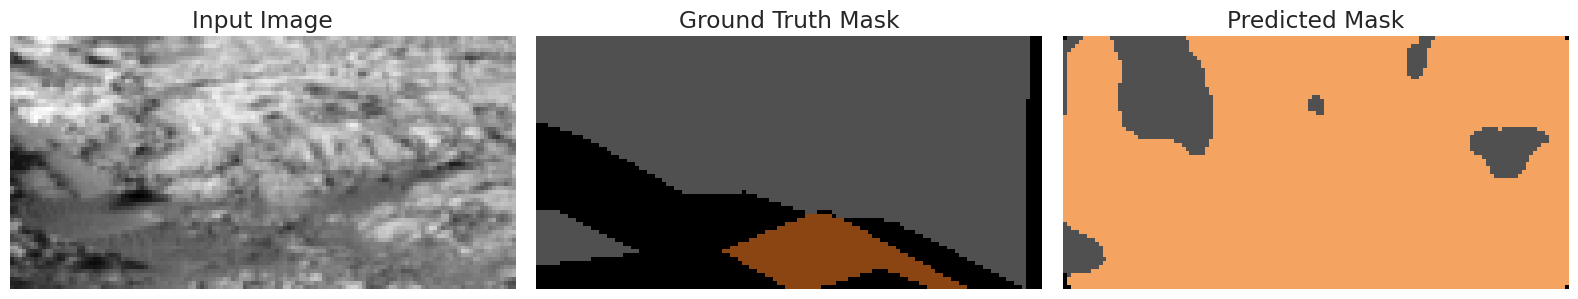

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.5255 - loss: 1.1241 - mean_iou: 0.3343 - val_accuracy: 0.2616 - val_loss: 1.8391 - val_mean_iou: 0.1031 - learning_rate: 0.0010
Epoch 17/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.5157 - loss: 1.1530 - mean_iou: 0.3322 - val_accuracy: 0.4661 - val_loss: 1.4239 - val_mean_iou: 0.2386 - learning_rate: 0.0010
Epoch 18/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.5135 - loss: 1.1527 - mean_iou: 0.3188 - val_accuracy: 0.2808 - val_loss: 1.5762 - val_mean_iou: 0.1289 - learning_rate: 0.0010
Epoch 19/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.5246 - loss: 1.1237 - mean_iou: 0.3333 - val_accuracy: 0.4838 - val_loss: 1.3188 - val_mean_iou: 0.2596 - learning_rate: 0.0010
Epoch 20/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.5708 - loss: 1.1245 - mean_iou: 0.3611 - val_accuracy: 0.3032 - val_loss: 1.6274 - val_mean_iou: 0.1421 - learning_rate: 0.0010
Epoch 21/1000
32/32 ━━━━

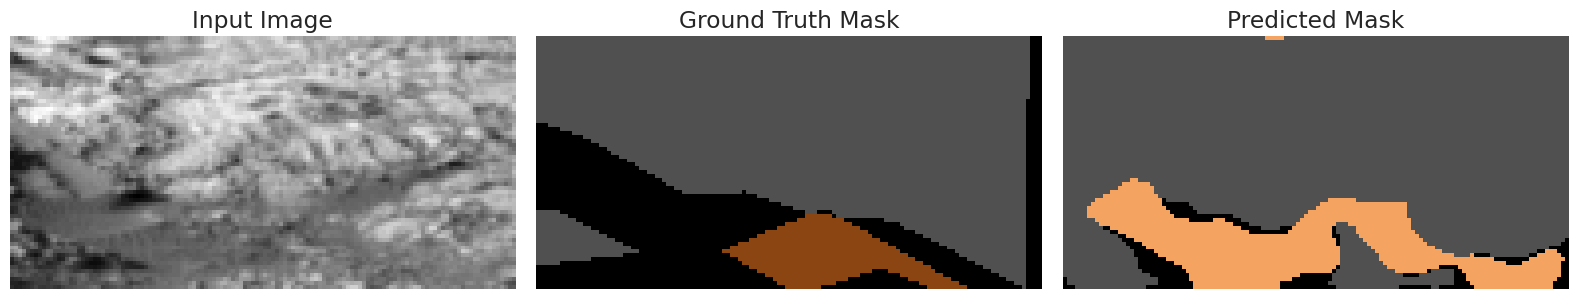

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.5534 - loss: 1.1050 - mean_iou: 0.3596 - val_accuracy: 0.3968 - val_loss: 1.5985 - val_mean_iou: 0.2171 - learning_rate: 0.0010
Epoch 22/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.5745 - loss: 1.0837 - mean_iou: 0.3821 - val_accuracy: 0.4894 - val_loss: 1.3207 - val_mean_iou: 0.2587 - learning_rate: 0.0010
Epoch 23/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.5713 - loss: 1.0955 - mean_iou: 0.3711 - val_accuracy: 0.5268 - val_loss: 1.1797 - val_mean_iou: 0.2907 - learning_rate: 0.0010
Epoch 24/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.5759 - loss: 1.0660 - mean_iou: 0.3759 - val_accuracy: 0.3964 - val_loss: 1.4571 - val_mean_iou: 0.1959 - learning_rate: 0.0010
Epoch 25/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.4748 - loss: 1.1473 - mean_iou: 0.2884 - val_accuracy: 0.4198 - val_loss: 1.3305 - val_mean_iou: 0.2434 - learning_rate: 0.0010
Epoch 26/1000
32/32 ━━━━

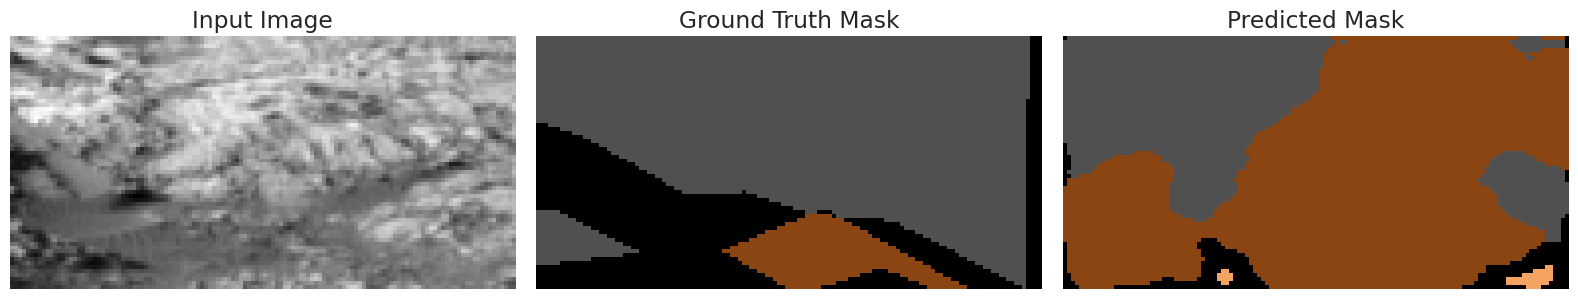

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.5471 - loss: 1.0924 - mean_iou: 0.3505 - val_accuracy: 0.4906 - val_loss: 1.2288 - val_mean_iou: 0.2711 - learning_rate: 0.0010
Epoch 27/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.5844 - loss: 1.0205 - mean_iou: 0.3798 - val_accuracy: 0.5647 - val_loss: 1.0991 - val_mean_iou: 0.3542 - learning_rate: 0.0010
Epoch 28/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.5786 - loss: 1.0430 - mean_iou: 0.3694 - val_accuracy: 0.3634 - val_loss: 1.3079 - val_mean_iou: 0.2170 - learning_rate: 0.0010
Epoch 29/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.5788 - loss: 1.0310 - mean_iou: 0.3732 - val_accuracy: 0.3314 - val_loss: 1.2294 - val_mean_iou: 0.1991 - learning_rate: 0.0010
Epoch 30/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.5876 - loss: 1.0164 - mean_iou: 0.3802 - val_accuracy: 0.3477 - val_loss: 1.2769 - val_mean_iou: 0.1851 - learning_rate: 0.0010
Epoch 31/1000
32/32 ━━━━

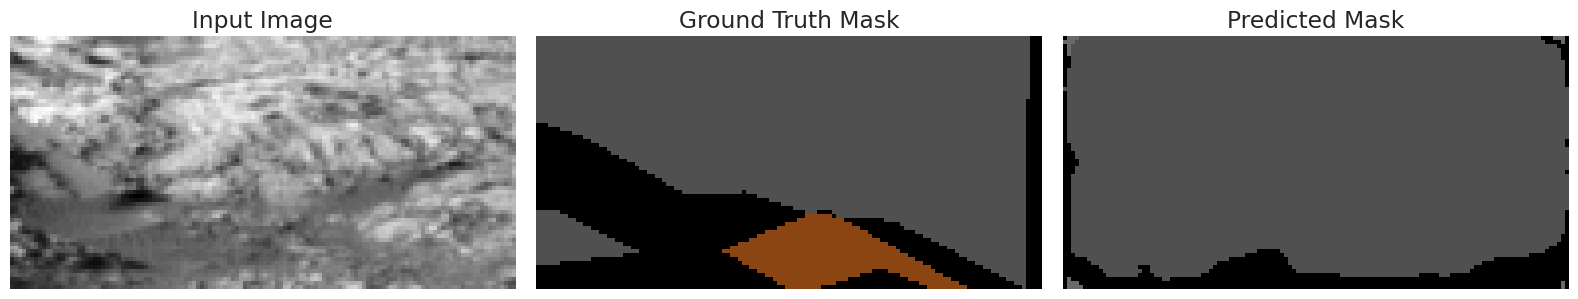

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - accuracy: 0.5628 - loss: 1.0825 - mean_iou: 0.3590 - val_accuracy: 0.2858 - val_loss: 1.5233 - val_mean_iou: 0.1379 - learning_rate: 0.0010
Epoch 32/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.5814 - loss: 1.0167 - mean_iou: 0.3886 - val_accuracy: 0.3294 - val_loss: 1.3415 - val_mean_iou: 0.1821 - learning_rate: 0.0010
Epoch 33/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.5971 - loss: 1.0158 - mean_iou: 0.3998 - val_accuracy: 0.3442 - val_loss: 1.4104 - val_mean_iou: 0.2177 - learning_rate: 0.0010
Epoch 34/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.5937 - loss: 0.9987 - mean_iou: 0.4004 - val_accuracy: 0.3235 - val_loss: 1.3479 - val_mean_iou: 0.1929 - learning_rate: 0.0010
Epoch 35/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.5428 - loss: 1.0712 - mean_iou: 0.3354 - val_accuracy: 0.2820 - val_loss: 1.4162 - val_mean_iou: 0.1536 - learning_rate: 0.0010
Epoch 36/1000
32/32 ━━━━

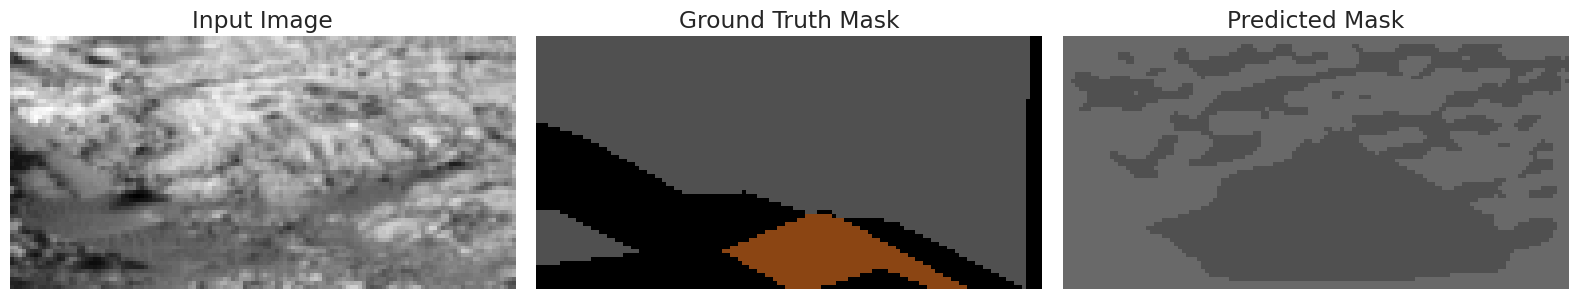

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.4850 - loss: 1.1393 - mean_iou: 0.2993 - val_accuracy: 0.0905 - val_loss: 1.8368 - val_mean_iou: 0.0446 - learning_rate: 0.0010
Epoch 37/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.5879 - loss: 1.0012 - mean_iou: 0.3813 - val_accuracy: 0.1759 - val_loss: 1.7952 - val_mean_iou: 0.0591 - learning_rate: 0.0010
Epoch 38/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.5927 - loss: 0.9581 - mean_iou: 0.3892 - val_accuracy: 0.1962 - val_loss: 1.5441 - val_mean_iou: 0.1197 - learning_rate: 0.0010
Epoch 39/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6116 - loss: 0.9448 - mean_iou: 0.4021 - val_accuracy: 0.4618 - val_loss: 1.1793 - val_mean_iou: 0.2593 - learning_rate: 0.0010
Epoch 40/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.6174 - loss: 0.9413 - mean_iou: 0.4029 - val_accuracy: 0.3000 - val_loss: 1.5971 - val_mean_iou: 0.1402 - learning_rate: 0.0010
Epoch 41/1000
32/32 ━━━━

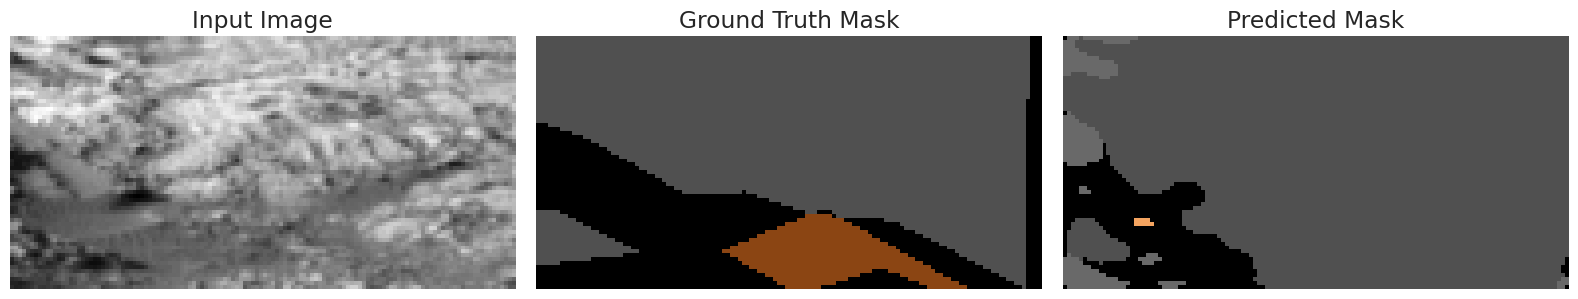

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.6070 - loss: 0.9478 - mean_iou: 0.3962 - val_accuracy: 0.3766 - val_loss: 1.2932 - val_mean_iou: 0.2001 - learning_rate: 0.0010
Epoch 42/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.6345 - loss: 0.9065 - mean_iou: 0.4208 - val_accuracy: 0.5795 - val_loss: 1.0861 - val_mean_iou: 0.3365 - learning_rate: 0.0010
Epoch 43/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.6394 - loss: 0.9127 - mean_iou: 0.4275 - val_accuracy: 0.5970 - val_loss: 1.0358 - val_mean_iou: 0.3752 - learning_rate: 1.0000e-04
Epoch 44/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.6378 - loss: 0.8900 - mean_iou: 0.4227 - val_accuracy: 0.5636 - val_loss: 1.0633 - val_mean_iou: 0.3446 - learning_rate: 1.0000e-04
Epoch 45/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.6494 - loss: 0.8523 - mean_iou: 0.4356 - val_accuracy: 0.6384 - val_loss: 0.9782 - val_mean_iou: 0.4125 - learning_rate: 1.0000e-04
Epoch 46/100

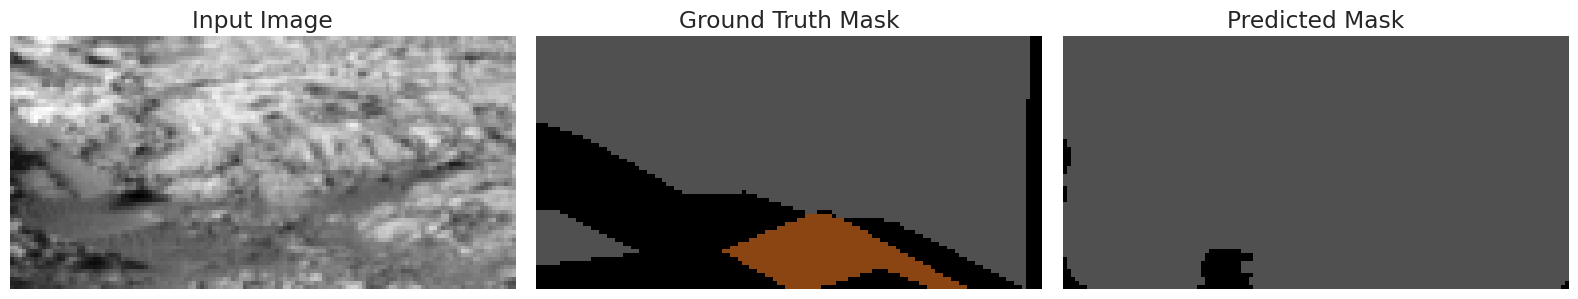

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.6520 - loss: 0.8723 - mean_iou: 0.4375 - val_accuracy: 0.6575 - val_loss: 0.9458 - val_mean_iou: 0.4300 - learning_rate: 1.0000e-04
Epoch 47/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.6470 - loss: 0.8664 - mean_iou: 0.4338 - val_accuracy: 0.6708 - val_loss: 0.9397 - val_mean_iou: 0.4410 - learning_rate: 1.0000e-04
Epoch 48/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.6531 - loss: 0.8530 - mean_iou: 0.4349 - val_accuracy: 0.6726 - val_loss: 0.9871 - val_mean_iou: 0.4413 - learning_rate: 1.0000e-04
Epoch 49/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6647 - loss: 0.8279 - mean_iou: 0.4459 - val_accuracy: 0.6749 - val_loss: 0.9723 - val_mean_iou: 0.4403 - learning_rate: 1.0000e-04
Epoch 50/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.6529 - loss: 0.8517 - mean_iou: 0.4379 - val_accuracy: 0.6649 - val_loss: 0.9831 - val_mean_iou: 0.4332 - learning_rate: 1.0000e-04
Epoc

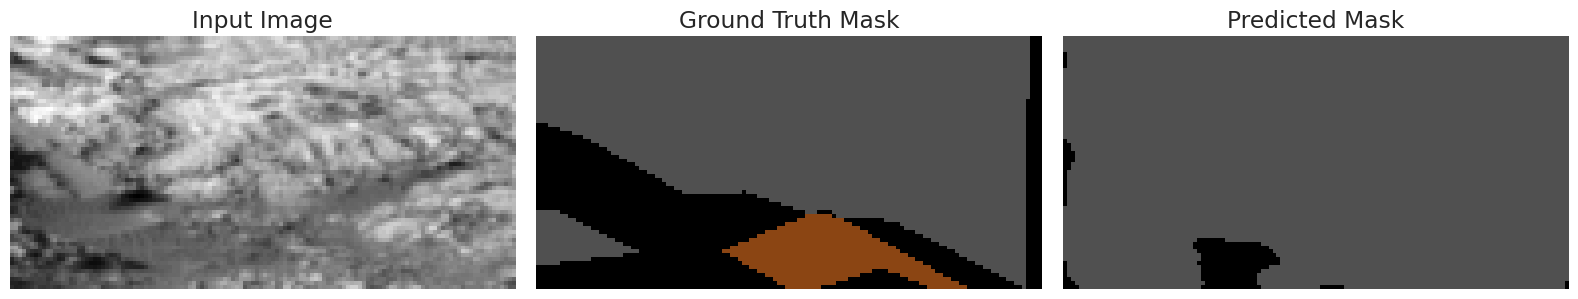

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 442ms/step - accuracy: 0.6572 - loss: 0.8444 - mean_iou: 0.4400 - val_accuracy: 0.6768 - val_loss: 0.9736 - val_mean_iou: 0.4439 - learning_rate: 1.0000e-04
Epoch 52/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.6661 - loss: 0.8199 - mean_iou: 0.4490 - val_accuracy: 0.6814 - val_loss: 1.0060 - val_mean_iou: 0.4441 - learning_rate: 1.0000e-04
Epoch 53/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.6620 - loss: 0.8226 - mean_iou: 0.4415 - val_accuracy: 0.6828 - val_loss: 1.0243 - val_mean_iou: 0.4475 - learning_rate: 1.0000e-04
Epoch 54/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.6703 - loss: 0.8171 - mean_iou: 0.4541 - val_accuracy: 0.6847 - val_loss: 1.0164 - val_mean_iou: 0.4491 - learning_rate: 1.0000e-04
Epoch 55/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6729 - loss: 0.8279 - mean_iou: 0.4541 - val_accuracy: 0.6723 - val_loss: 1.0517 - val_mean_iou: 0.4278 - learning_rate: 1.0000e-04
Epoc

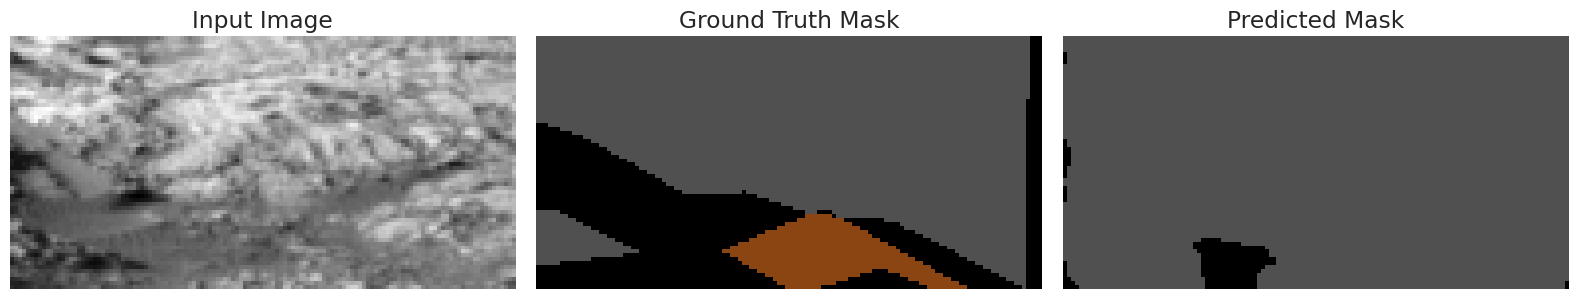

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.6710 - loss: 0.8199 - mean_iou: 0.4529 - val_accuracy: 0.6769 - val_loss: 0.9927 - val_mean_iou: 0.4468 - learning_rate: 1.0000e-04
Epoch 57/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.6754 - loss: 0.7871 - mean_iou: 0.4580 - val_accuracy: 0.6835 - val_loss: 0.9909 - val_mean_iou: 0.4522 - learning_rate: 1.0000e-04
Epoch 58/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6678 - loss: 0.8136 - mean_iou: 0.4497 - val_accuracy: 0.6755 - val_loss: 0.9635 - val_mean_iou: 0.4424 - learning_rate: 1.0000e-04
Epoch 59/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6771 - loss: 0.8229 - mean_iou: 0.4595 - val_accuracy: 0.6780 - val_loss: 0.9528 - val_mean_iou: 0.4435 - learning_rate: 1.0000e-04
Epoch 60/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.6737 - loss: 0.8128 - mean_iou: 0.4584 - val_accuracy: 0.6863 - val_loss: 1.0051 - val_mean_iou: 0.4505 - learning_rate: 1.0000e-04
Epoc

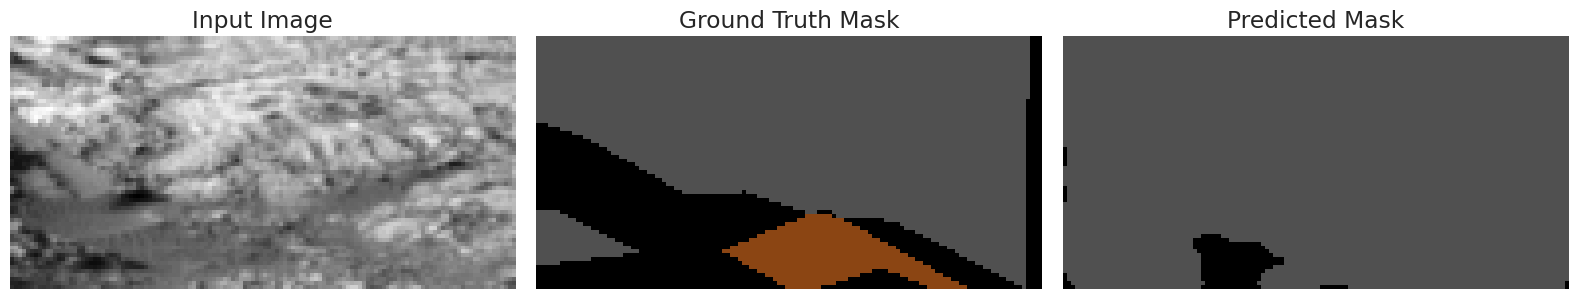

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.6703 - loss: 0.8180 - mean_iou: 0.4554 - val_accuracy: 0.6802 - val_loss: 0.9849 - val_mean_iou: 0.4455 - learning_rate: 1.0000e-04
Epoch 62/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6776 - loss: 0.8013 - mean_iou: 0.4587 - val_accuracy: 0.6787 - val_loss: 1.0001 - val_mean_iou: 0.4402 - learning_rate: 1.0000e-04
Epoch 63/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.6704 - loss: 0.8250 - mean_iou: 0.4536 - val_accuracy: 0.6752 - val_loss: 0.9738 - val_mean_iou: 0.4468 - learning_rate: 1.0000e-04
Epoch 64/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6772 - loss: 0.8011 - mean_iou: 0.4602 - val_accuracy: 0.6719 - val_loss: 1.0096 - val_mean_iou: 0.4438 - learning_rate: 1.0000e-04
Epoch 65/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6782 - loss: 0.7991 - mean_iou: 0.4615 - val_accuracy: 0.6801 - val_loss: 1.0416 - val_mean_iou: 0.4496 - learning_rate: 1.0000e-04
Epoc

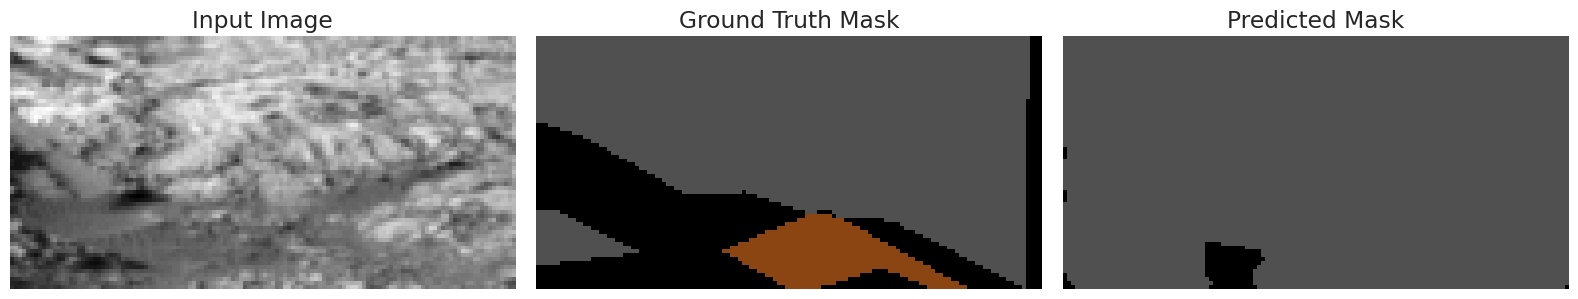

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.6793 - loss: 0.7910 - mean_iou: 0.4635 - val_accuracy: 0.6844 - val_loss: 0.9988 - val_mean_iou: 0.4529 - learning_rate: 1.0000e-04
Epoch 67/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.6766 - loss: 0.7920 - mean_iou: 0.4598 - val_accuracy: 0.6938 - val_loss: 0.9764 - val_mean_iou: 0.4594 - learning_rate: 1.0000e-04
Epoch 68/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.6891 - loss: 0.7842 - mean_iou: 0.4696 - val_accuracy: 0.6913 - val_loss: 1.0064 - val_mean_iou: 0.4489 - learning_rate: 1.0000e-04
Epoch 69/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6830 - loss: 0.7916 - mean_iou: 0.4627 - val_accuracy: 0.6767 - val_loss: 0.9354 - val_mean_iou: 0.4436 - learning_rate: 1.0000e-04
Epoch 70/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.6838 - loss: 0.7889 - mean_iou: 0.4660 - val_accuracy: 0.6569 - val_loss: 0.9748 - val_mean_iou: 0.4244 - learning_rate: 1.0000e-04
Epoc

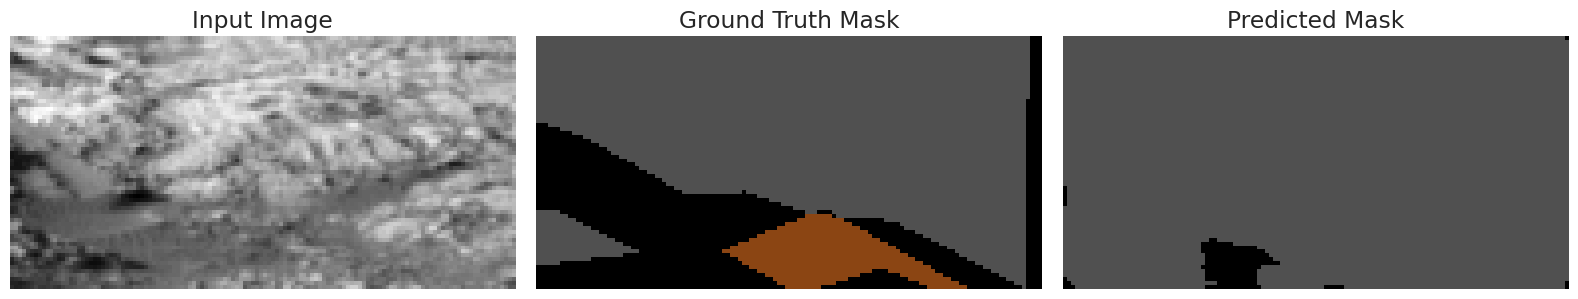

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 450ms/step - accuracy: 0.6834 - loss: 0.7830 - mean_iou: 0.4606 - val_accuracy: 0.6909 - val_loss: 0.9812 - val_mean_iou: 0.4556 - learning_rate: 1.0000e-04
Epoch 72/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.6850 - loss: 0.7748 - mean_iou: 0.4638 - val_accuracy: 0.6994 - val_loss: 0.9931 - val_mean_iou: 0.4608 - learning_rate: 1.0000e-04
Epoch 73/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6920 - loss: 0.7774 - mean_iou: 0.4709 - val_accuracy: 0.6964 - val_loss: 0.9834 - val_mean_iou: 0.4587 - learning_rate: 1.0000e-04
Epoch 74/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6951 - loss: 0.7633 - mean_iou: 0.4770 - val_accuracy: 0.6953 - val_loss: 1.0041 - val_mean_iou: 0.4502 - learning_rate: 1.0000e-04
Epoch 75/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6907 - loss: 0.7700 - mean_iou: 0.4747 - val_accuracy: 0.7009 - val_loss: 0.9650 - val_mean_iou: 0.4595 - learning_rate: 1.0000e-04
Epoc

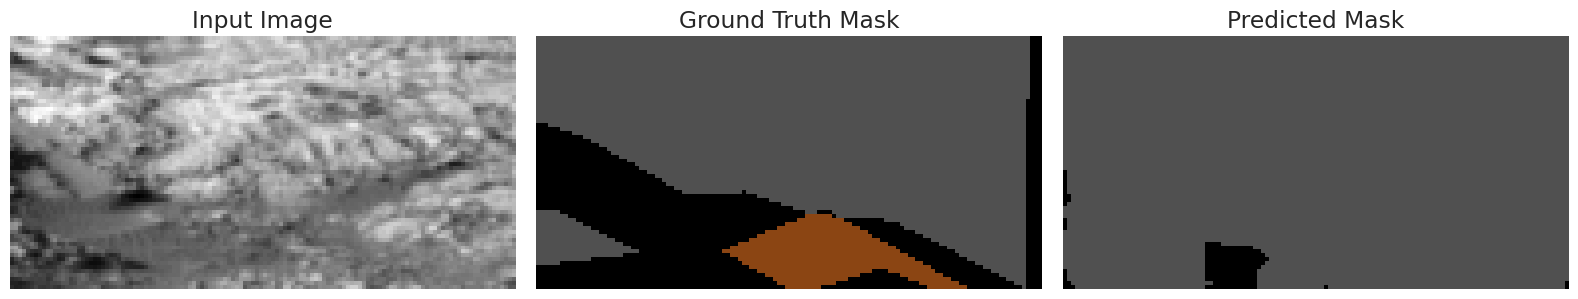

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 441ms/step - accuracy: 0.6928 - loss: 0.7588 - mean_iou: 0.4725 - val_accuracy: 0.7026 - val_loss: 0.9915 - val_mean_iou: 0.4614 - learning_rate: 1.0000e-04
Epoch 77/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.6955 - loss: 0.7668 - mean_iou: 0.4816 - val_accuracy: 0.7020 - val_loss: 0.9965 - val_mean_iou: 0.4616 - learning_rate: 1.0000e-04
Epoch 78/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6995 - loss: 0.7536 - mean_iou: 0.4773 - val_accuracy: 0.7012 - val_loss: 1.0161 - val_mean_iou: 0.4537 - learning_rate: 1.0000e-04
Epoch 79/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6975 - loss: 0.7613 - mean_iou: 0.4756 - val_accuracy: 0.7007 - val_loss: 1.0033 - val_mean_iou: 0.4550 - learning_rate: 1.0000e-04
Epoch 80/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.6918 - loss: 0.7615 - mean_iou: 0.4659 - val_accuracy: 0.7011 - val_loss: 0.9671 - val_mean_iou: 0.4628 - learning_rate: 1.0000e-04
Epoc

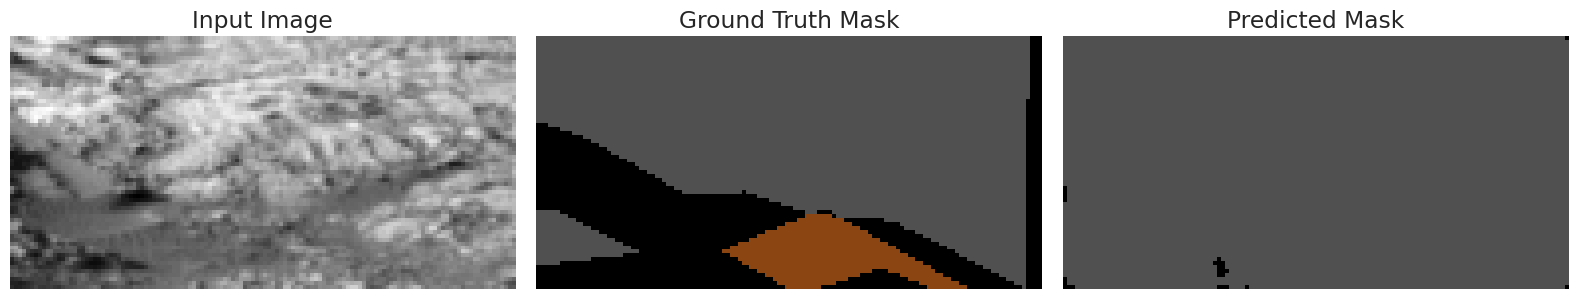

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 442ms/step - accuracy: 0.7009 - loss: 0.7428 - mean_iou: 0.4782 - val_accuracy: 0.7032 - val_loss: 1.0207 - val_mean_iou: 0.4635 - learning_rate: 1.0000e-04
Epoch 82/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7044 - loss: 0.7562 - mean_iou: 0.4810 - val_accuracy: 0.7026 - val_loss: 0.9082 - val_mean_iou: 0.4627 - learning_rate: 1.0000e-04
Epoch 83/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6991 - loss: 0.7504 - mean_iou: 0.4773 - val_accuracy: 0.7069 - val_loss: 1.0115 - val_mean_iou: 0.4586 - learning_rate: 1.0000e-04
Epoch 84/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.7070 - loss: 0.7294 - mean_iou: 0.4802 - val_accuracy: 0.7093 - val_loss: 0.9586 - val_mean_iou: 0.4640 - learning_rate: 1.0000e-04
Epoch 85/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7107 - loss: 0.7297 - mean_iou: 0.4870 - val_accuracy: 0.7015 - val_loss: 0.9780 - val_mean_iou: 0.4524 - learning_rate: 1.0000e-04
Epoc

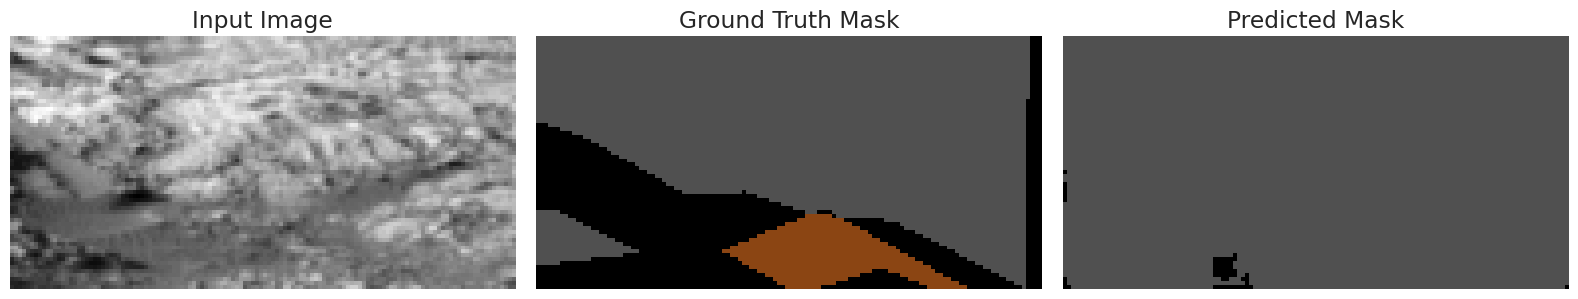

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.7027 - loss: 0.7435 - mean_iou: 0.4736 - val_accuracy: 0.7028 - val_loss: 0.9748 - val_mean_iou: 0.4628 - learning_rate: 1.0000e-04
Epoch 87/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.7095 - loss: 0.7303 - mean_iou: 0.4771 - val_accuracy: 0.7131 - val_loss: 1.0100 - val_mean_iou: 0.4642 - learning_rate: 1.0000e-04
Epoch 88/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7101 - loss: 0.7309 - mean_iou: 0.4875 - val_accuracy: 0.6993 - val_loss: 1.0275 - val_mean_iou: 0.4436 - learning_rate: 1.0000e-04
Epoch 89/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7064 - loss: 0.7354 - mean_iou: 0.4770 - val_accuracy: 0.7053 - val_loss: 1.0321 - val_mean_iou: 0.4539 - learning_rate: 1.0000e-04
Epoch 90/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7188 - loss: 0.7151 - mean_iou: 0.4883 - val_accuracy: 0.7173 - val_loss: 1.0082 - val_mean_iou: 0.4594 - learning_rate: 1.0000e-04
Epoc

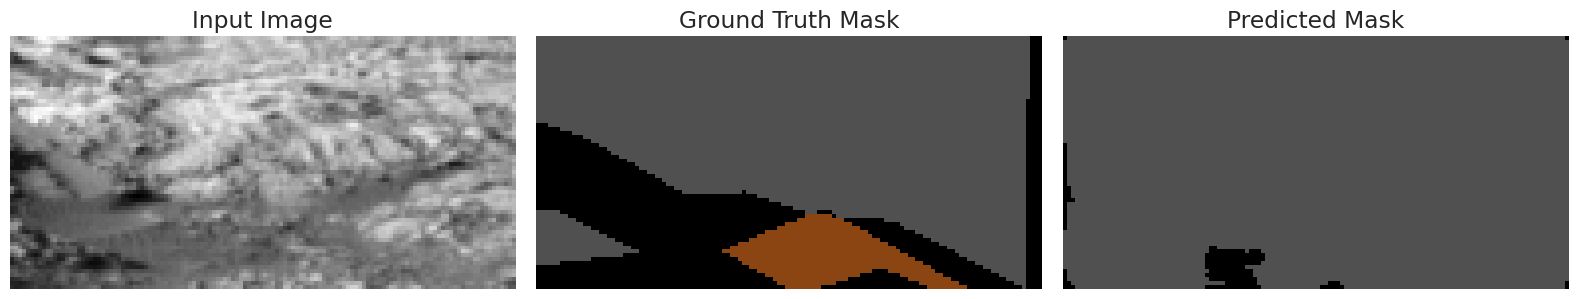

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.7126 - loss: 0.7257 - mean_iou: 0.4837 - val_accuracy: 0.7067 - val_loss: 0.9925 - val_mean_iou: 0.4491 - learning_rate: 1.0000e-04
Epoch 92/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7073 - loss: 0.7289 - mean_iou: 0.4750 - val_accuracy: 0.7099 - val_loss: 0.9704 - val_mean_iou: 0.4539 - learning_rate: 1.0000e-04
Epoch 93/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7049 - loss: 0.7229 - mean_iou: 0.4734 - val_accuracy: 0.7209 - val_loss: 0.9949 - val_mean_iou: 0.4604 - learning_rate: 1.0000e-04
Epoch 94/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7155 - loss: 0.7320 - mean_iou: 0.4870 - val_accuracy: 0.6685 - val_loss: 0.8697 - val_mean_iou: 0.4304 - learning_rate: 1.0000e-04
Epoch 95/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7039 - loss: 0.7524 - mean_iou: 0.4754 - val_accuracy: 0.6523 - val_loss: 0.9679 - val_mean_iou: 0.4055 - learning_rate: 1.0000e-04
Epoc

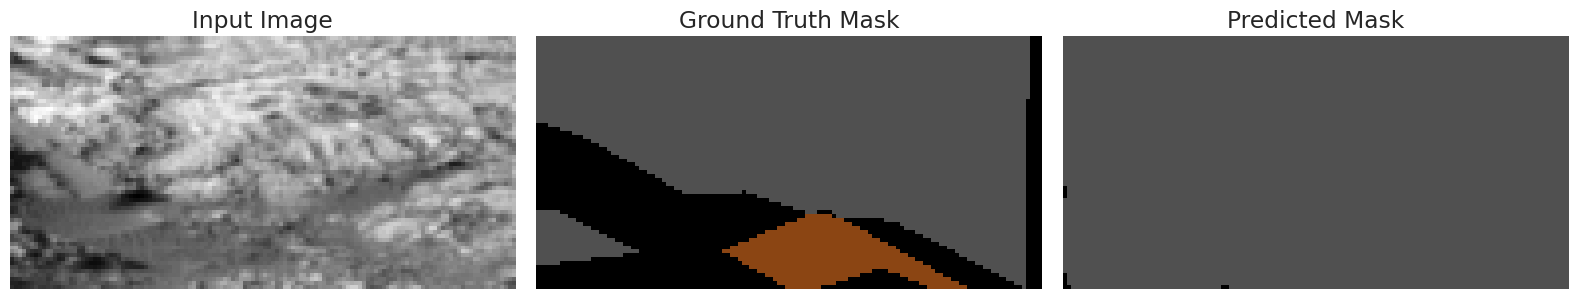

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.6976 - loss: 0.7428 - mean_iou: 0.4638 - val_accuracy: 0.6776 - val_loss: 1.0175 - val_mean_iou: 0.4272 - learning_rate: 1.0000e-04
Epoch 97/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7154 - loss: 0.7246 - mean_iou: 0.4781 - val_accuracy: 0.7095 - val_loss: 0.9953 - val_mean_iou: 0.4579 - learning_rate: 1.0000e-04
Epoch 98/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.7215 - loss: 0.7181 - mean_iou: 0.4939 - val_accuracy: 0.7208 - val_loss: 1.0001 - val_mean_iou: 0.4666 - learning_rate: 1.0000e-04
Epoch 99/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7238 - loss: 0.7044 - mean_iou: 0.4869 - val_accuracy: 0.7161 - val_loss: 0.9800 - val_mean_iou: 0.4601 - learning_rate: 1.0000e-04
Epoch 100/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.7215 - loss: 0.7068 - mean_iou: 0.4850 - val_accuracy: 0.7260 - val_loss: 0.9659 - val_mean_iou: 0.4674 - learning_rate: 1.0000e-04
Epo

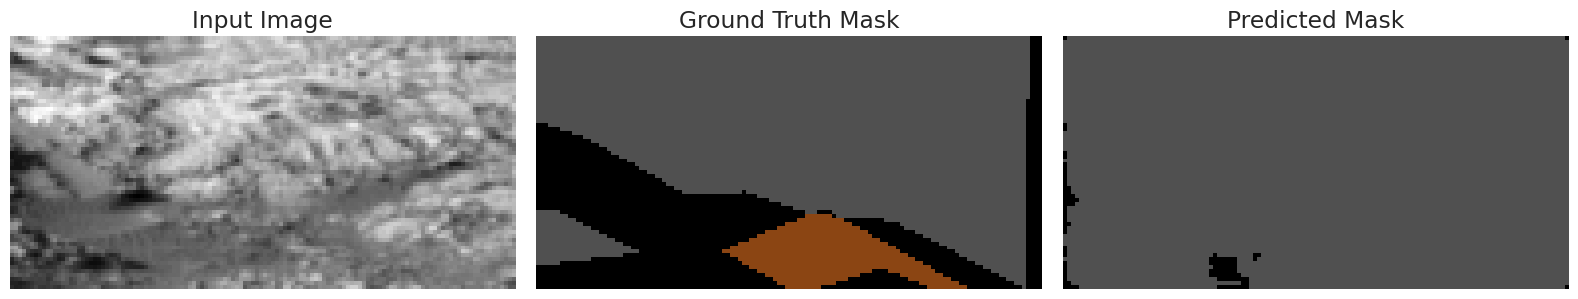

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.7239 - loss: 0.6976 - mean_iou: 0.4868 - val_accuracy: 0.7271 - val_loss: 0.9751 - val_mean_iou: 0.4631 - learning_rate: 1.0000e-04
Epoch 102/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7254 - loss: 0.7121 - mean_iou: 0.4919 - val_accuracy: 0.7301 - val_loss: 0.9674 - val_mean_iou: 0.4632 - learning_rate: 1.0000e-04
Epoch 103/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7158 - loss: 0.7090 - mean_iou: 0.4802 - val_accuracy: 0.6232 - val_loss: 1.0098 - val_mean_iou: 0.3705 - learning_rate: 1.0000e-04
Epoch 104/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7047 - loss: 0.7472 - mean_iou: 0.4650 - val_accuracy: 0.7095 - val_loss: 0.9146 - val_mean_iou: 0.4649 - learning_rate: 1.0000e-04
Epoch 105/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7181 - loss: 0.7076 - mean_iou: 0.4826 - val_accuracy: 0.7205 - val_loss: 0.9185 - val_mean_iou: 0.4621 - learning_rate: 1.0000e-04


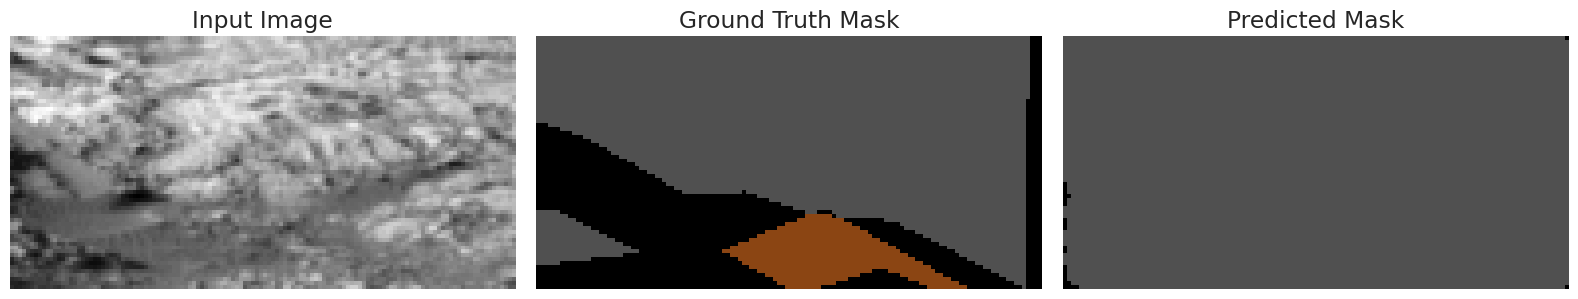

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.7307 - loss: 0.7015 - mean_iou: 0.4893 - val_accuracy: 0.7234 - val_loss: 0.9033 - val_mean_iou: 0.4583 - learning_rate: 1.0000e-04
Epoch 107/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7309 - loss: 0.6897 - mean_iou: 0.4894 - val_accuracy: 0.7307 - val_loss: 0.9663 - val_mean_iou: 0.4647 - learning_rate: 1.0000e-04
Epoch 108/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7304 - loss: 0.7049 - mean_iou: 0.4956 - val_accuracy: 0.7313 - val_loss: 0.9706 - val_mean_iou: 0.4644 - learning_rate: 1.0000e-04
Epoch 109/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7324 - loss: 0.6788 - mean_iou: 0.4890 - val_accuracy: 0.7210 - val_loss: 0.9904 - val_mean_iou: 0.4503 - learning_rate: 1.0000e-04
Epoch 110/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7339 - loss: 0.6884 - mean_iou: 0.4994 - val_accuracy: 0.7239 - val_loss: 0.9758 - val_mean_iou: 0.4523 - learning_rate: 1.0000e-04


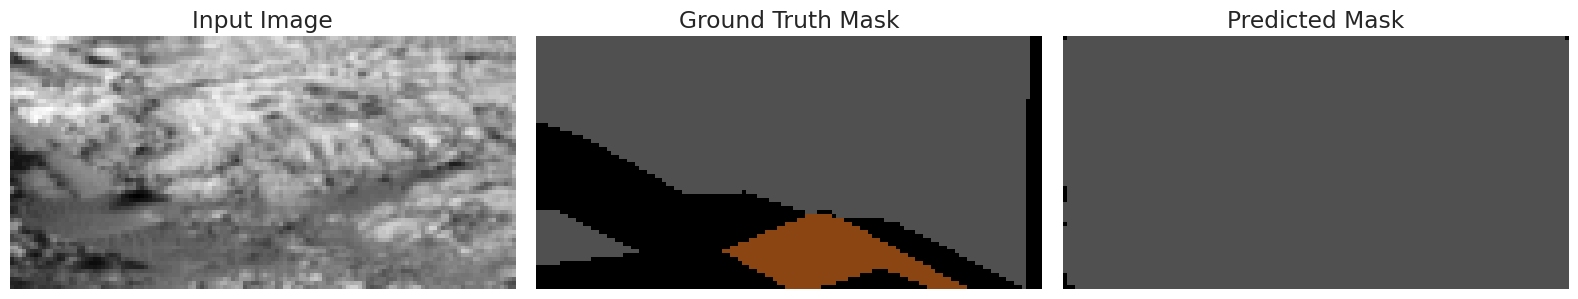

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.7396 - loss: 0.6819 - mean_iou: 0.5087 - val_accuracy: 0.7357 - val_loss: 1.0024 - val_mean_iou: 0.4677 - learning_rate: 1.0000e-04
Epoch 112/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.7447 - loss: 0.6704 - mean_iou: 0.5071 - val_accuracy: 0.7401 - val_loss: 0.9729 - val_mean_iou: 0.4708 - learning_rate: 1.0000e-04
Epoch 113/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.7371 - loss: 0.6810 - mean_iou: 0.5081 - val_accuracy: 0.7386 - val_loss: 0.9938 - val_mean_iou: 0.4765 - learning_rate: 1.0000e-04
Epoch 114/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7410 - loss: 0.6698 - mean_iou: 0.5089 - val_accuracy: 0.7316 - val_loss: 0.9274 - val_mean_iou: 0.4596 - learning_rate: 1.0000e-04
Epoch 115/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7402 - loss: 0.6698 - mean_iou: 0.5005 - val_accuracy: 0.7286 - val_loss: 0.9897 - val_mean_iou: 0.4645 - learning_rate: 1.0000e-04


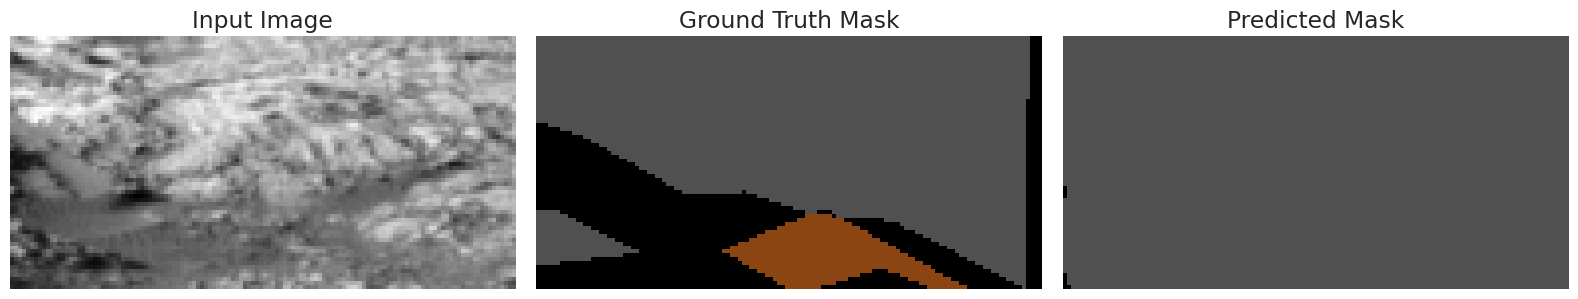

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.7457 - loss: 0.6683 - mean_iou: 0.5160 - val_accuracy: 0.7352 - val_loss: 0.9953 - val_mean_iou: 0.4663 - learning_rate: 1.0000e-04
Epoch 117/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7421 - loss: 0.6625 - mean_iou: 0.5040 - val_accuracy: 0.7456 - val_loss: 0.9825 - val_mean_iou: 0.4739 - learning_rate: 1.0000e-04
Epoch 118/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7433 - loss: 0.6660 - mean_iou: 0.5175 - val_accuracy: 0.7441 - val_loss: 1.0009 - val_mean_iou: 0.4752 - learning_rate: 1.0000e-04
Epoch 119/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7431 - loss: 0.6673 - mean_iou: 0.5067 - val_accuracy: 0.7394 - val_loss: 1.0171 - val_mean_iou: 0.4716 - learning_rate: 1.0000e-04
Epoch 120/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.7448 - loss: 0.6606 - mean_iou: 0.5101 - val_accuracy: 0.7391 - val_loss: 0.9402 - val_mean_iou: 0.4655 - learning_rate: 1.0000e-04


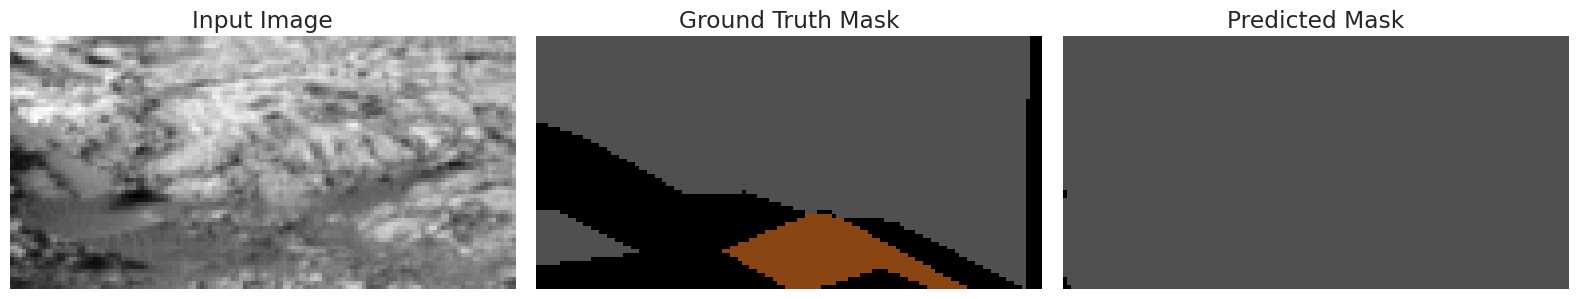

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.7488 - loss: 0.6535 - mean_iou: 0.5184 - val_accuracy: 0.7504 - val_loss: 0.9868 - val_mean_iou: 0.4805 - learning_rate: 1.0000e-04
Epoch 122/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7444 - loss: 0.6584 - mean_iou: 0.5079 - val_accuracy: 0.7324 - val_loss: 0.9588 - val_mean_iou: 0.4518 - learning_rate: 1.0000e-04
Epoch 123/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7495 - loss: 0.6698 - mean_iou: 0.5098 - val_accuracy: 0.7444 - val_loss: 0.9949 - val_mean_iou: 0.4718 - learning_rate: 1.0000e-04
Epoch 124/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7495 - loss: 0.6493 - mean_iou: 0.5194 - val_accuracy: 0.7408 - val_loss: 1.0147 - val_mean_iou: 0.4688 - learning_rate: 1.0000e-04
Epoch 125/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7466 - loss: 0.6579 - mean_iou: 0.5024 - val_accuracy: 0.7302 - val_loss: 0.9768 - val_mean_iou: 0.4558 - learning_rate: 1.0000e-04


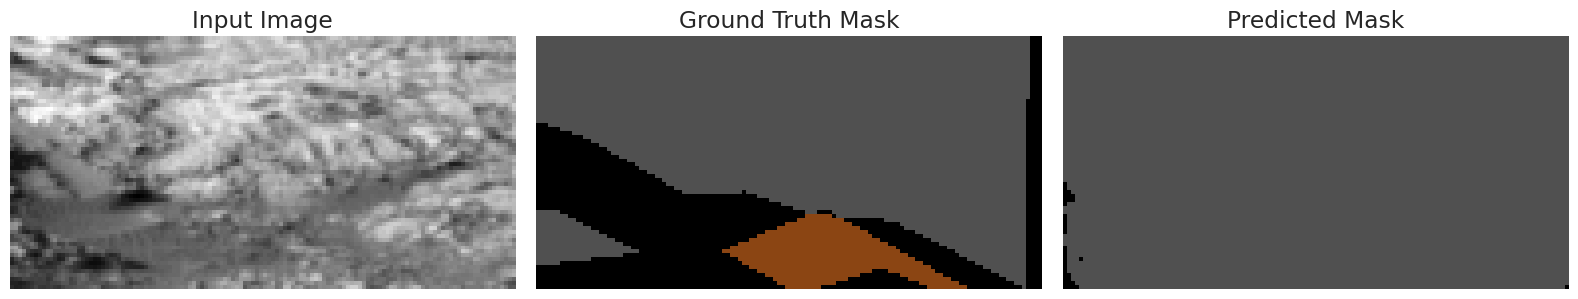

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - accuracy: 0.7520 - loss: 0.6492 - mean_iou: 0.5088 - val_accuracy: 0.7355 - val_loss: 0.9778 - val_mean_iou: 0.4575 - learning_rate: 1.0000e-04
Epoch 127/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7489 - loss: 0.6493 - mean_iou: 0.5146 - val_accuracy: 0.7396 - val_loss: 0.9621 - val_mean_iou: 0.4726 - learning_rate: 1.0000e-04
Epoch 128/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7552 - loss: 0.6333 - mean_iou: 0.5207 - val_accuracy: 0.7429 - val_loss: 1.0656 - val_mean_iou: 0.4726 - learning_rate: 1.0000e-04
Epoch 129/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7453 - loss: 0.6726 - mean_iou: 0.5055 - val_accuracy: 0.7113 - val_loss: 1.0520 - val_mean_iou: 0.4288 - learning_rate: 1.0000e-04
Epoch 130/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7339 - loss: 0.6732 - mean_iou: 0.4904 - val_accuracy: 0.7438 - val_loss: 0.9905 - val_mean_iou: 0.4710 - learning_rate: 1.0000e-04


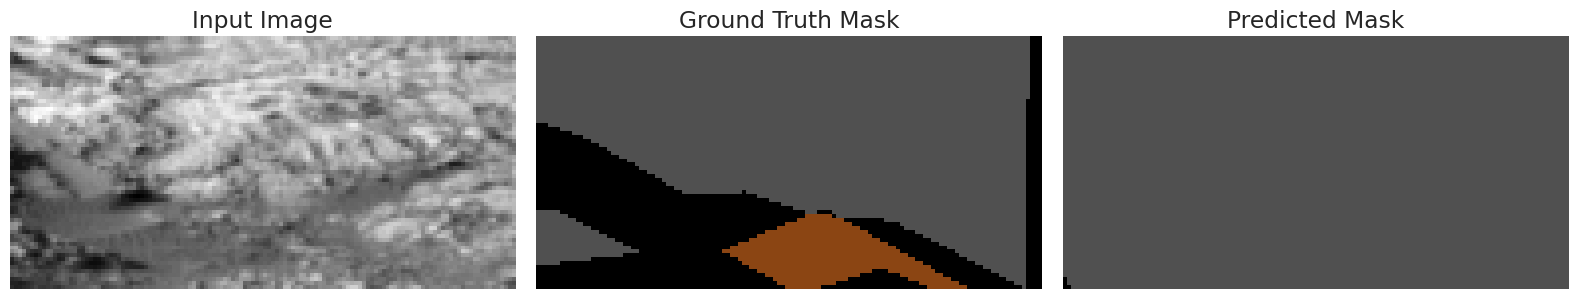

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.7452 - loss: 0.6502 - mean_iou: 0.5109 - val_accuracy: 0.7451 - val_loss: 1.0096 - val_mean_iou: 0.4748 - learning_rate: 1.0000e-04
Epoch 132/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7584 - loss: 0.6272 - mean_iou: 0.5267 - val_accuracy: 0.7491 - val_loss: 0.9881 - val_mean_iou: 0.4770 - learning_rate: 1.0000e-04
Epoch 133/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7475 - loss: 0.6424 - mean_iou: 0.5223 - val_accuracy: 0.7359 - val_loss: 1.0235 - val_mean_iou: 0.4646 - learning_rate: 1.0000e-04
Epoch 134/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.7533 - loss: 0.6356 - mean_iou: 0.5207 - val_accuracy: 0.7513 - val_loss: 1.0294 - val_mean_iou: 0.4808 - learning_rate: 1.0000e-04
Epoch 135/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7603 - loss: 0.6193 - mean_iou: 0.5184 - val_accuracy: 0.7514 - val_loss: 1.0757 - val_mean_iou: 0.4758 - learning_rate: 1.0000e-04


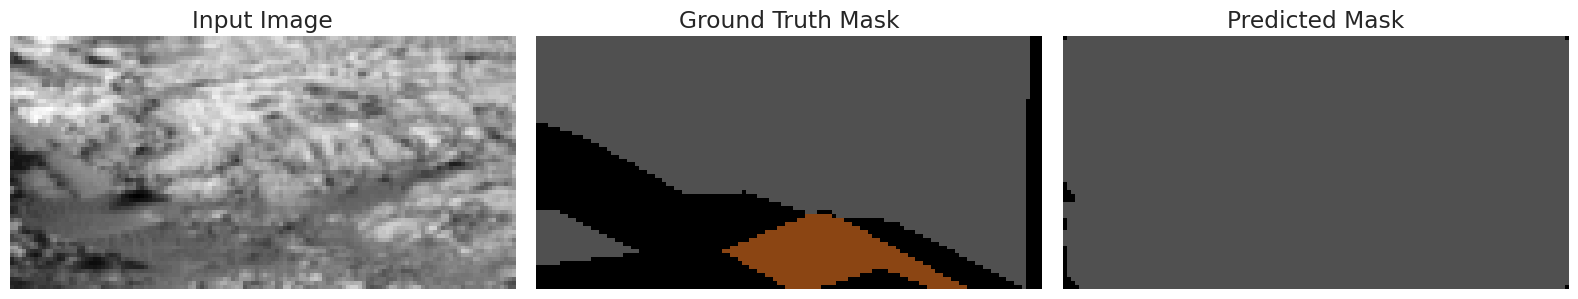

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.7580 - loss: 0.6289 - mean_iou: 0.5341 - val_accuracy: 0.7509 - val_loss: 1.1013 - val_mean_iou: 0.4744 - learning_rate: 1.0000e-04
Epoch 137/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7621 - loss: 0.6261 - mean_iou: 0.5384 - val_accuracy: 0.7546 - val_loss: 1.0397 - val_mean_iou: 0.4794 - learning_rate: 1.0000e-04
Epoch 138/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.7558 - loss: 0.6219 - mean_iou: 0.5322 - val_accuracy: 0.7554 - val_loss: 1.0340 - val_mean_iou: 0.4830 - learning_rate: 1.0000e-04
Epoch 139/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7651 - loss: 0.6109 - mean_iou: 0.5303 - val_accuracy: 0.7488 - val_loss: 1.0150 - val_mean_iou: 0.4689 - learning_rate: 1.0000e-04
Epoch 140/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7563 - loss: 0.6264 - mean_iou: 0.5216 - val_accuracy: 0.7482 - val_loss: 1.0834 - val_mean_iou: 0.4769 - learning_rate: 1.0000e-04


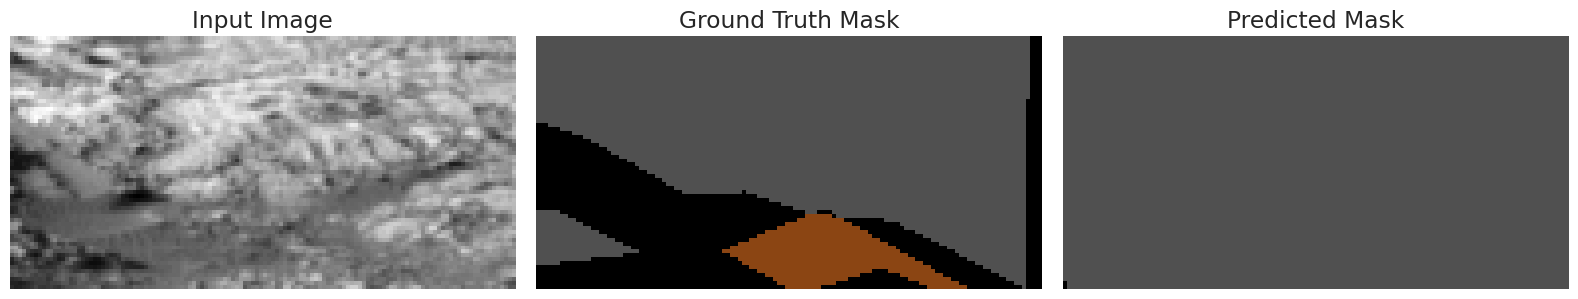

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.7528 - loss: 0.6334 - mean_iou: 0.5145 - val_accuracy: 0.6603 - val_loss: 0.9254 - val_mean_iou: 0.4156 - learning_rate: 1.0000e-04
Epoch 142/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7456 - loss: 0.6430 - mean_iou: 0.5017 - val_accuracy: 0.7372 - val_loss: 1.0487 - val_mean_iou: 0.4713 - learning_rate: 1.0000e-04
Epoch 143/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.7519 - loss: 0.6302 - mean_iou: 0.5249 - val_accuracy: 0.7580 - val_loss: 1.0188 - val_mean_iou: 0.4762 - learning_rate: 1.0000e-04
Epoch 144/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7589 - loss: 0.6130 - mean_iou: 0.5315 - val_accuracy: 0.7593 - val_loss: 0.9920 - val_mean_iou: 0.4760 - learning_rate: 1.0000e-04
Epoch 145/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7605 - loss: 0.6171 - mean_iou: 0.5224 - val_accuracy: 0.7573 - val_loss: 1.0434 - val_mean_iou: 0.4746 - learning_rate: 1.0000e-04


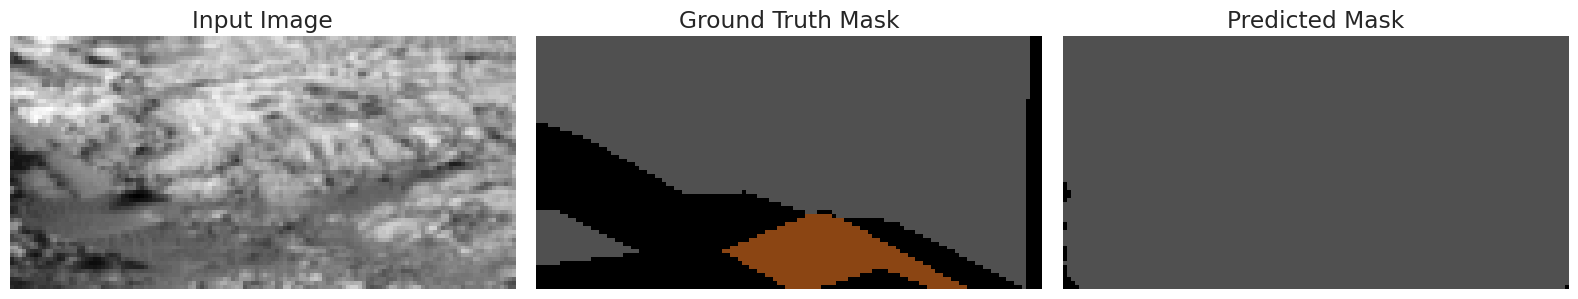

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.7638 - loss: 0.6096 - mean_iou: 0.5449 - val_accuracy: 0.7555 - val_loss: 1.0211 - val_mean_iou: 0.4819 - learning_rate: 1.0000e-04
Epoch 147/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7640 - loss: 0.6033 - mean_iou: 0.5441 - val_accuracy: 0.7519 - val_loss: 1.0561 - val_mean_iou: 0.4726 - learning_rate: 1.0000e-04
Epoch 148/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7644 - loss: 0.6043 - mean_iou: 0.5349 - val_accuracy: 0.7371 - val_loss: 1.0330 - val_mean_iou: 0.4500 - learning_rate: 1.0000e-04
Epoch 149/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7503 - loss: 0.6295 - mean_iou: 0.5110 - val_accuracy: 0.7362 - val_loss: 1.0706 - val_mean_iou: 0.4523 - learning_rate: 1.0000e-04
Epoch 150/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7569 - loss: 0.6201 - mean_iou: 0.5244 - val_accuracy: 0.7501 - val_loss: 1.0454 - val_mean_iou: 0.4738 - learning_rate: 1.0000e-04


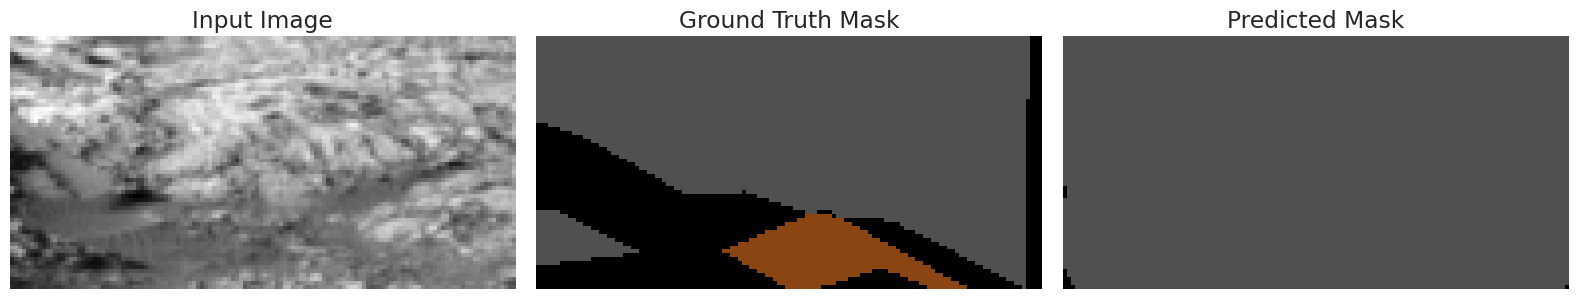

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.7660 - loss: 0.6049 - mean_iou: 0.5515 - val_accuracy: 0.7561 - val_loss: 1.1098 - val_mean_iou: 0.4816 - learning_rate: 1.0000e-04
Epoch 152/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7709 - loss: 0.5997 - mean_iou: 0.5425 - val_accuracy: 0.7475 - val_loss: 1.0172 - val_mean_iou: 0.4748 - learning_rate: 1.0000e-04
Epoch 153/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7595 - loss: 0.6185 - mean_iou: 0.5105 - val_accuracy: 0.7403 - val_loss: 1.0496 - val_mean_iou: 0.4684 - learning_rate: 1.0000e-04
Epoch 154/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7580 - loss: 0.6131 - mean_iou: 0.5052 - val_accuracy: 0.7463 - val_loss: 1.0421 - val_mean_iou: 0.4739 - learning_rate: 1.0000e-05
Epoch 155/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7618 - loss: 0.6110 - mean_iou: 0.5135 - val_accuracy: 0.7496 - val_loss: 1.0302 - val_mean_iou: 0.4766 - learning_rate: 1.0000e-05


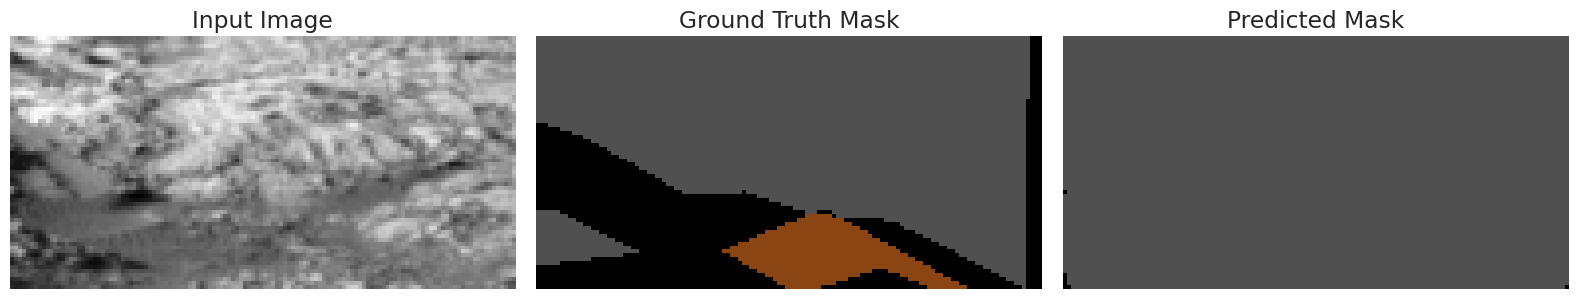

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.7630 - loss: 0.6099 - mean_iou: 0.5229 - val_accuracy: 0.7513 - val_loss: 1.0271 - val_mean_iou: 0.4778 - learning_rate: 1.0000e-05
Epoch 157/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7743 - loss: 0.5868 - mean_iou: 0.5263 - val_accuracy: 0.7543 - val_loss: 1.0276 - val_mean_iou: 0.4810 - learning_rate: 1.0000e-05
Epoch 158/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.7689 - loss: 0.6012 - mean_iou: 0.5354 - val_accuracy: 0.7591 - val_loss: 1.0243 - val_mean_iou: 0.4863 - learning_rate: 1.0000e-05
Epoch 159/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.7757 - loss: 0.5895 - mean_iou: 0.5374 - val_accuracy: 0.7613 - val_loss: 1.0150 - val_mean_iou: 0.4868 - learning_rate: 1.0000e-05
Epoch 160/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7668 - loss: 0.5969 - mean_iou: 0.5291 - val_accuracy: 0.7616 - val_loss: 1.0146 - val_mean_iou: 0.4864 - learning_rate: 1.0000e-05


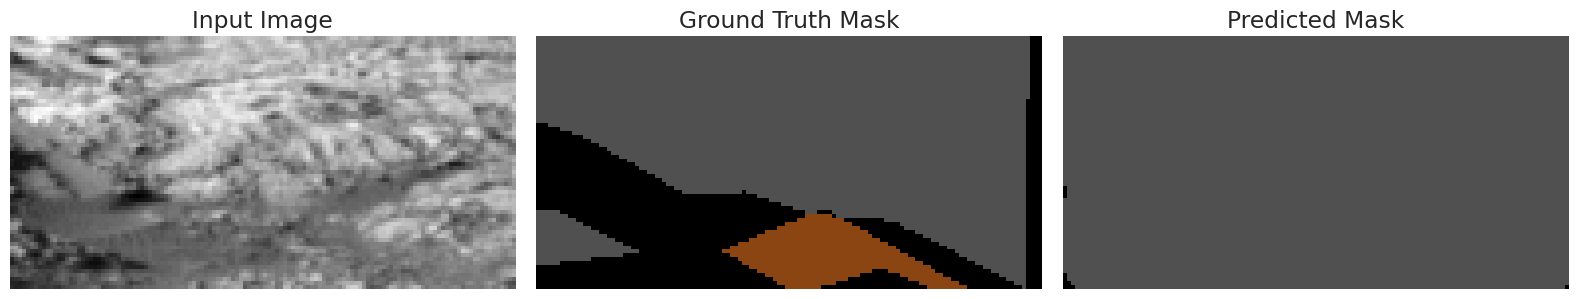

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - accuracy: 0.7721 - loss: 0.5867 - mean_iou: 0.5361 - val_accuracy: 0.7616 - val_loss: 1.0034 - val_mean_iou: 0.4861 - learning_rate: 1.0000e-05
Epoch 162/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7776 - loss: 0.5808 - mean_iou: 0.5480 - val_accuracy: 0.7611 - val_loss: 1.0062 - val_mean_iou: 0.4862 - learning_rate: 1.0000e-05
Epoch 163/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7789 - loss: 0.5822 - mean_iou: 0.5440 - val_accuracy: 0.7611 - val_loss: 1.0147 - val_mean_iou: 0.4861 - learning_rate: 1.0000e-05
Epoch 164/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.7748 - loss: 0.5845 - mean_iou: 0.5392 - val_accuracy: 0.7609 - val_loss: 1.0228 - val_mean_iou: 0.4876 - learning_rate: 1.0000e-05
Epoch 165/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7762 - loss: 0.5823 - mean_iou: 0.5408 - val_accuracy: 0.7589 - val_loss: 1.0041 - val_mean_iou: 0.4861 - learning_rate: 1.0000e-05


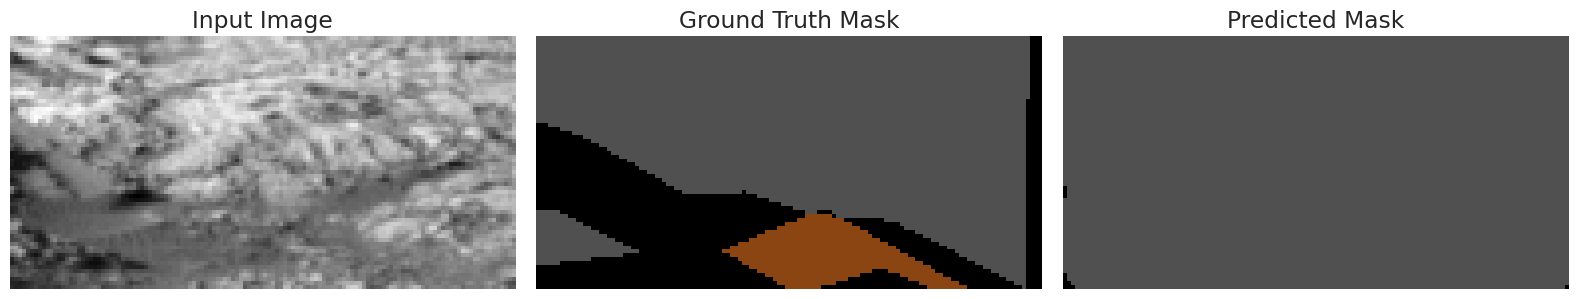

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.7649 - loss: 0.5987 - mean_iou: 0.5315 - val_accuracy: 0.7596 - val_loss: 1.0093 - val_mean_iou: 0.4859 - learning_rate: 1.0000e-05
Epoch 167/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7643 - loss: 0.5966 - mean_iou: 0.5252 - val_accuracy: 0.7602 - val_loss: 1.0154 - val_mean_iou: 0.4858 - learning_rate: 1.0000e-05
Epoch 168/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7722 - loss: 0.5867 - mean_iou: 0.5370 - val_accuracy: 0.7612 - val_loss: 1.0137 - val_mean_iou: 0.4862 - learning_rate: 1.0000e-05
Epoch 169/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7744 - loss: 0.5904 - mean_iou: 0.5340 - val_accuracy: 0.7547 - val_loss: 0.9870 - val_mean_iou: 0.4802 - learning_rate: 1.0000e-05
Epoch 170/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7694 - loss: 0.5884 - mean_iou: 0.5326 - val_accuracy: 0.7568 - val_loss: 1.0015 - val_mean_iou: 0.4852 - learning_rate: 1.0000e-05


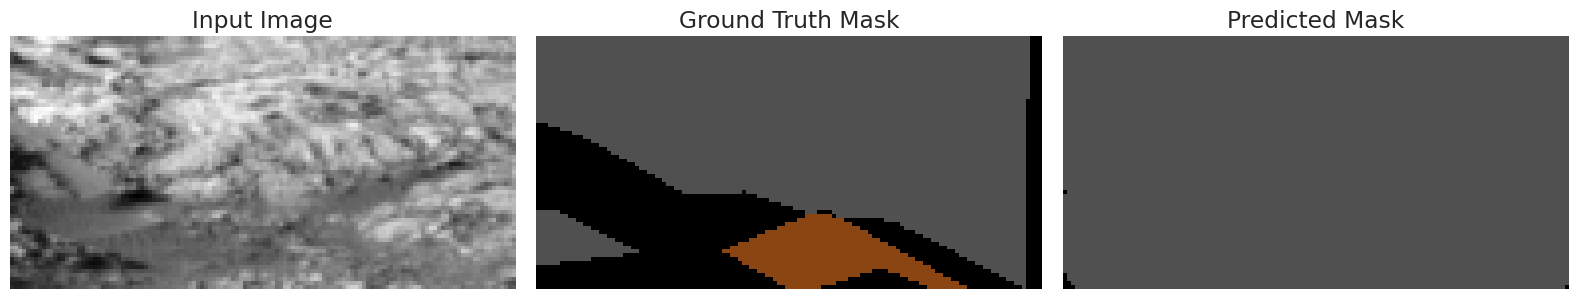

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.7704 - loss: 0.5844 - mean_iou: 0.5306 - val_accuracy: 0.7571 - val_loss: 1.0128 - val_mean_iou: 0.4860 - learning_rate: 1.0000e-05
Epoch 172/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7765 - loss: 0.5832 - mean_iou: 0.5418 - val_accuracy: 0.7588 - val_loss: 1.0112 - val_mean_iou: 0.4870 - learning_rate: 1.0000e-05
Epoch 173/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7757 - loss: 0.5867 - mean_iou: 0.5440 - val_accuracy: 0.7587 - val_loss: 1.0132 - val_mean_iou: 0.4863 - learning_rate: 1.0000e-05
Epoch 174/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7731 - loss: 0.5828 - mean_iou: 0.5444 - val_accuracy: 0.7584 - val_loss: 1.0135 - val_mean_iou: 0.4856 - learning_rate: 1.0000e-05
Epoch 175/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7745 - loss: 0.5841 - mean_iou: 0.5485 - val_accuracy: 0.7582 - val_loss: 1.0041 - val_mean_iou: 0.4857 - learning_rate: 1.0000e-05


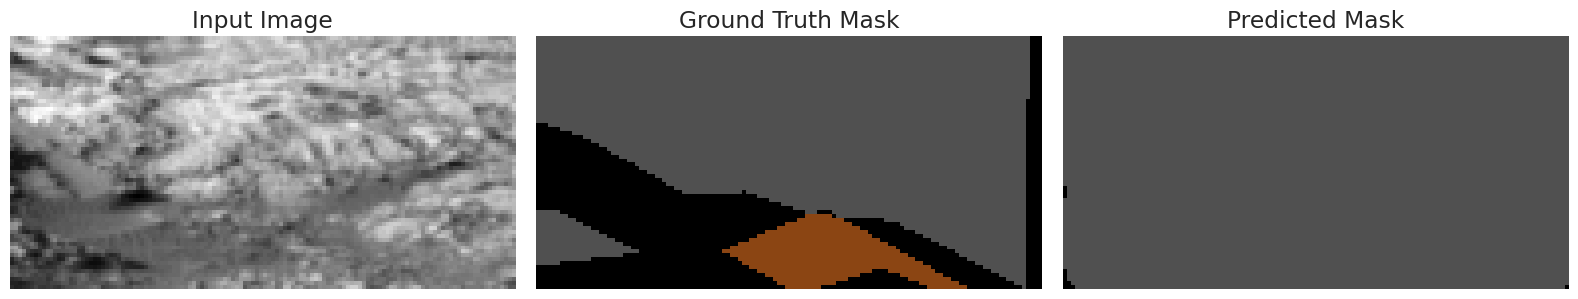

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.7785 - loss: 0.5882 - mean_iou: 0.5557 - val_accuracy: 0.7602 - val_loss: 1.0027 - val_mean_iou: 0.4869 - learning_rate: 1.0000e-05
Epoch 177/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7704 - loss: 0.5879 - mean_iou: 0.5412 - val_accuracy: 0.7602 - val_loss: 1.0012 - val_mean_iou: 0.4875 - learning_rate: 1.0000e-05
Epoch 178/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7747 - loss: 0.5862 - mean_iou: 0.5416 - val_accuracy: 0.7591 - val_loss: 0.9993 - val_mean_iou: 0.4860 - learning_rate: 1.0000e-05
Epoch 179/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7761 - loss: 0.5788 - mean_iou: 0.5412 - val_accuracy: 0.7591 - val_loss: 1.0143 - val_mean_iou: 0.4860 - learning_rate: 1.0000e-05
Epoch 180/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7746 - loss: 0.5823 - mean_iou: 0.5505 - val_accuracy: 0.7572 - val_loss: 1.0267 - val_mean_iou: 0.4832 - learning_rate: 1.0000e-05


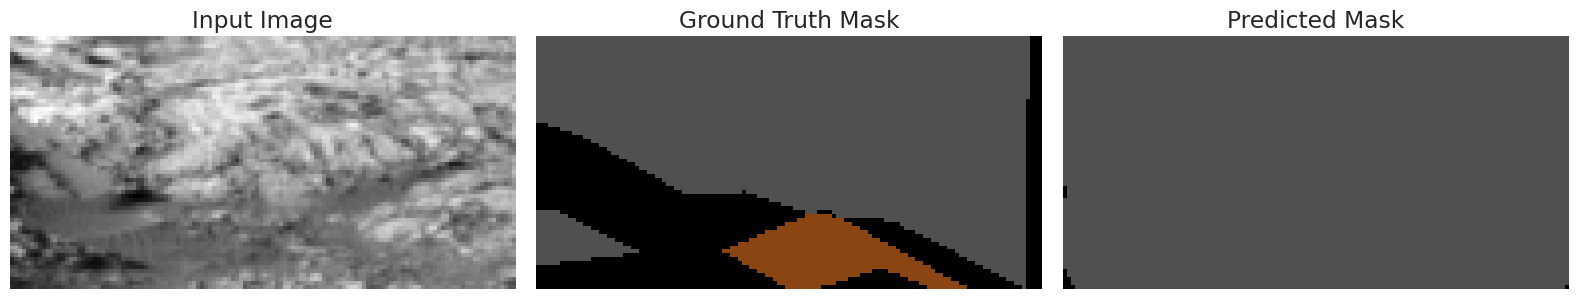

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - accuracy: 0.7770 - loss: 0.5831 - mean_iou: 0.5533 - val_accuracy: 0.7595 - val_loss: 1.0207 - val_mean_iou: 0.4848 - learning_rate: 1.0000e-05
Epoch 182/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7768 - loss: 0.5814 - mean_iou: 0.5539 - val_accuracy: 0.7597 - val_loss: 1.0192 - val_mean_iou: 0.4857 - learning_rate: 1.0000e-05
Epoch 183/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7783 - loss: 0.5787 - mean_iou: 0.5542 - val_accuracy: 0.7603 - val_loss: 1.0155 - val_mean_iou: 0.4854 - learning_rate: 1.0000e-05
Epoch 184/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.7758 - loss: 0.5762 - mean_iou: 0.5486 - val_accuracy: 0.7599 - val_loss: 1.0184 - val_mean_iou: 0.4854 - learning_rate: 1.0000e-05
Epoch 185/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7729 - loss: 0.5868 - mean_iou: 0.5449 - val_accuracy: 0.7609 - val_loss: 1.0177 - val_mean_iou: 0.4860 - learning_rate: 1.0000e-05


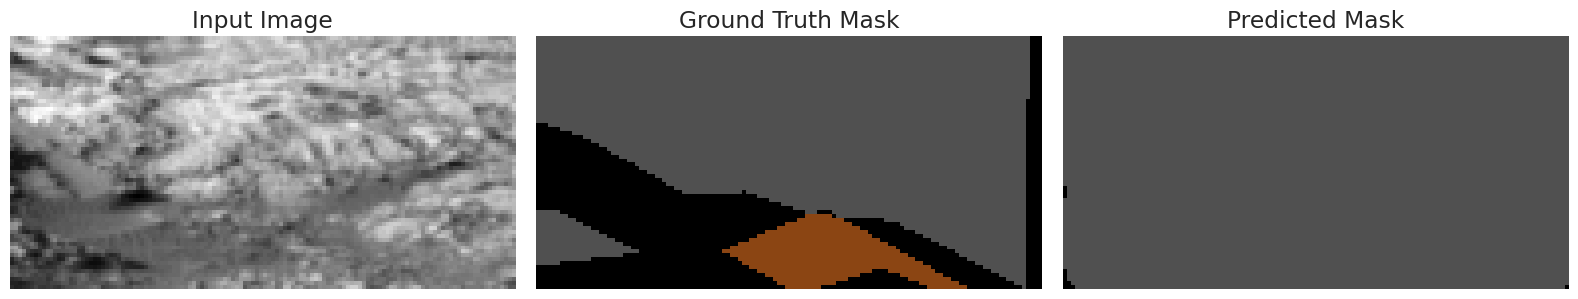

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.7796 - loss: 0.5739 - mean_iou: 0.5483 - val_accuracy: 0.7604 - val_loss: 1.0207 - val_mean_iou: 0.4863 - learning_rate: 1.0000e-05
Epoch 187/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7731 - loss: 0.5869 - mean_iou: 0.5519 - val_accuracy: 0.7624 - val_loss: 1.0146 - val_mean_iou: 0.4874 - learning_rate: 1.0000e-05
Epoch 188/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.7693 - loss: 0.5861 - mean_iou: 0.5324 - val_accuracy: 0.7611 - val_loss: 1.0171 - val_mean_iou: 0.4863 - learning_rate: 1.0000e-05
Epoch 189/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7803 - loss: 0.5770 - mean_iou: 0.5565 - val_accuracy: 0.7601 - val_loss: 1.0214 - val_mean_iou: 0.4855 - learning_rate: 1.0000e-05
Epoch 190/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.7787 - loss: 0.5793 - mean_iou: 0.5624 - val_accuracy: 0.7611 - val_loss: 1.0123 - val_mean_iou: 0.4863 - learning_rate: 1.0000e-05


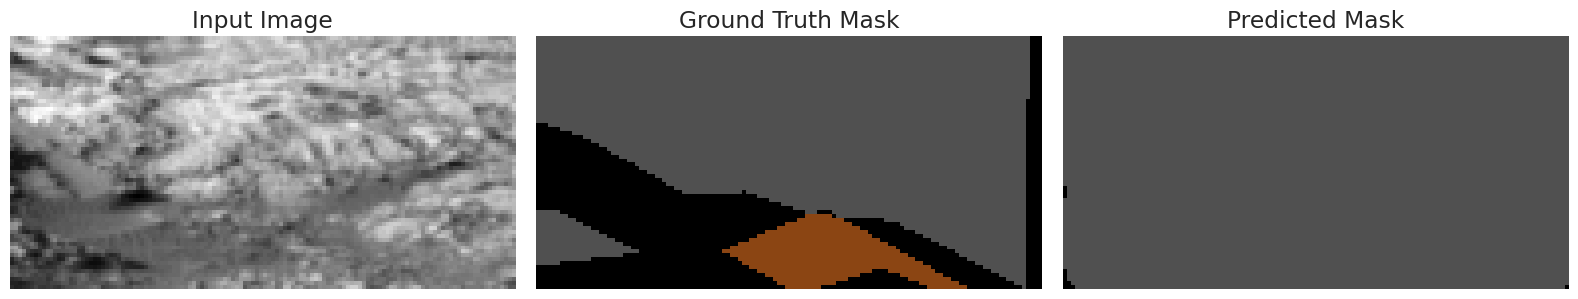

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.7817 - loss: 0.5757 - mean_iou: 0.5727 - val_accuracy: 0.7605 - val_loss: 1.0207 - val_mean_iou: 0.4862 - learning_rate: 1.0000e-05
Epoch 192/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.7840 - loss: 0.5655 - mean_iou: 0.5605 - val_accuracy: 0.7619 - val_loss: 1.0218 - val_mean_iou: 0.4866 - learning_rate: 1.0000e-05
Epoch 193/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.7762 - loss: 0.5751 - mean_iou: 0.5628 - val_accuracy: 0.7618 - val_loss: 1.0141 - val_mean_iou: 0.4866 - learning_rate: 1.0000e-05
Epoch 194/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.7791 - loss: 0.5754 - mean_iou: 0.5615 - val_accuracy: 0.7620 - val_loss: 1.0137 - val_mean_iou: 0.4873 - learning_rate: 1.0000e-05
Final validation Mean Intersection Over Union: 48.76%


In [26]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, learning_rate, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

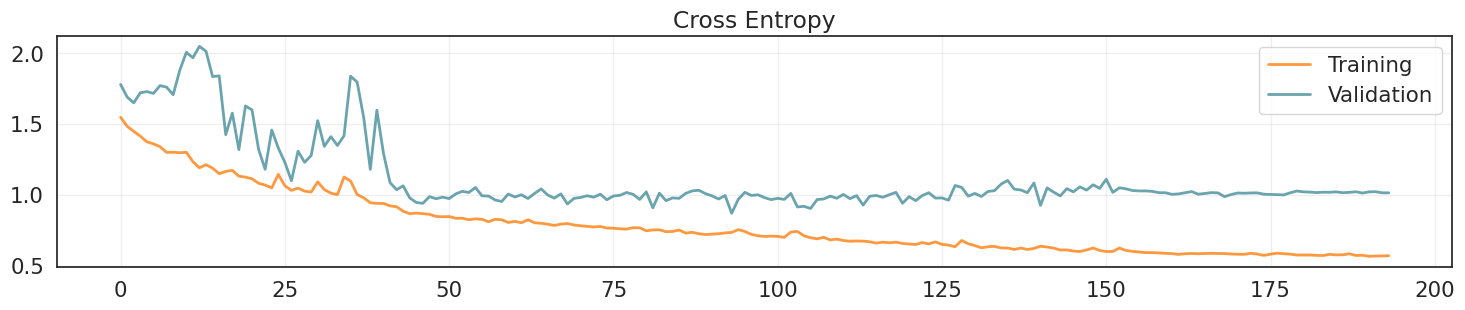

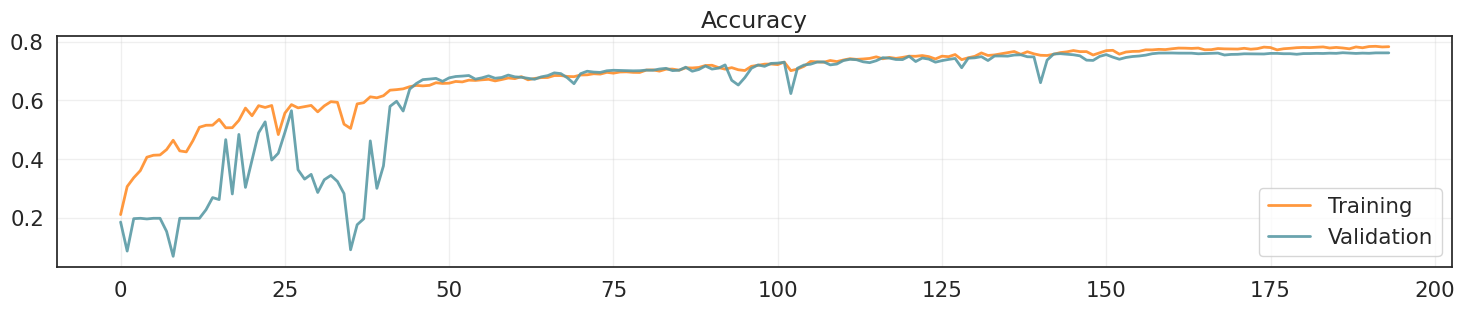

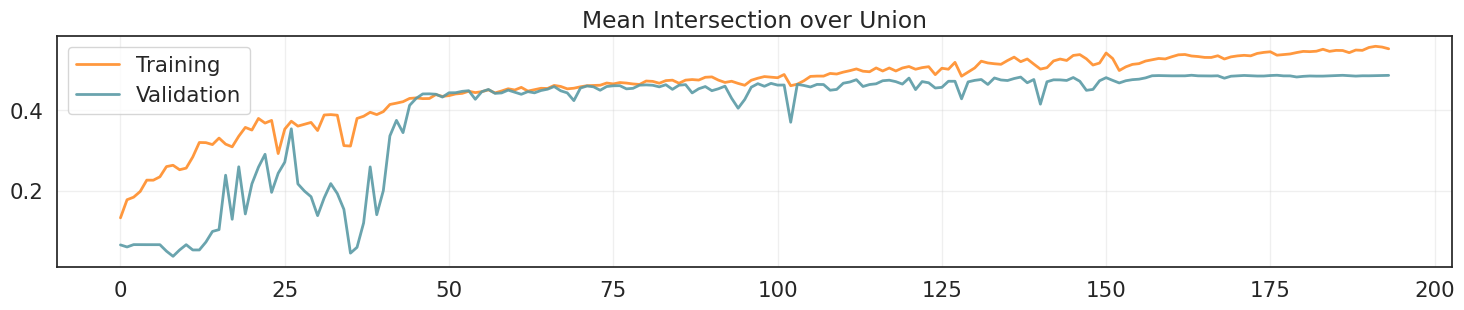

In [30]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔮 Predictions on the Test Set

In [33]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [35]:
model_filename = 'UNet_48.76.keras'
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_48.76.keras


In [36]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step
Predictions shape: (10022, 64, 128)


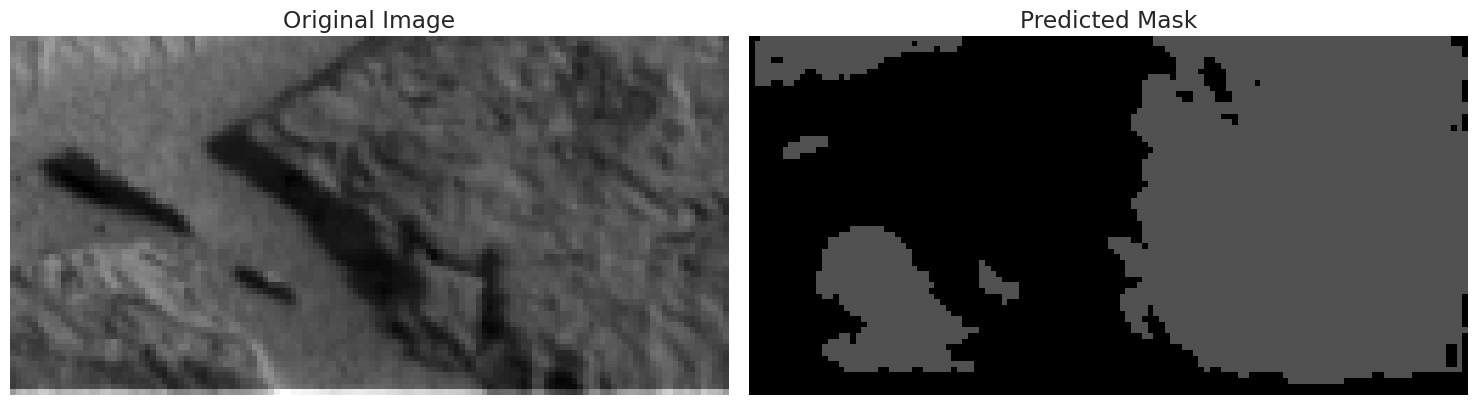

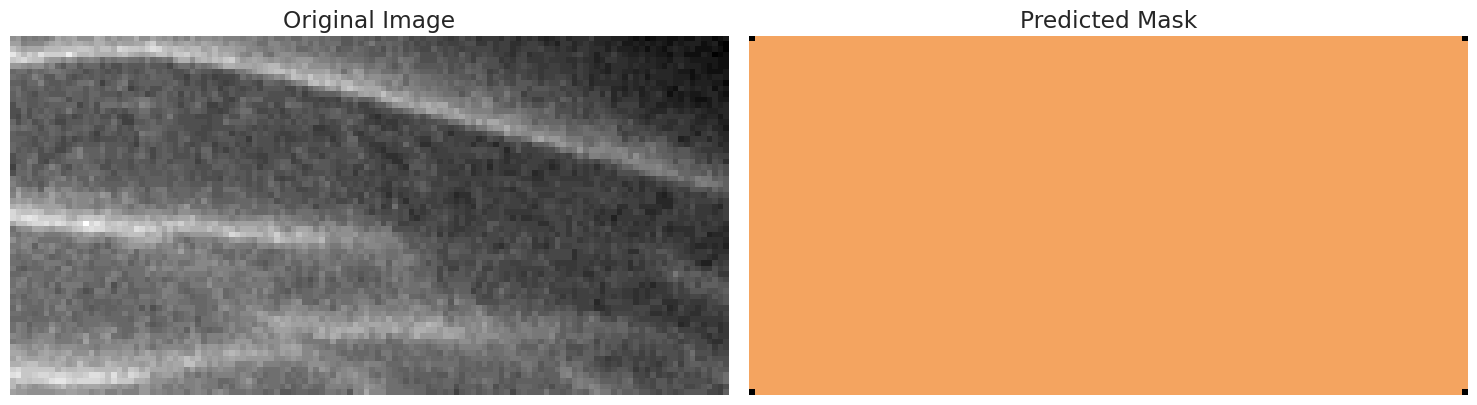

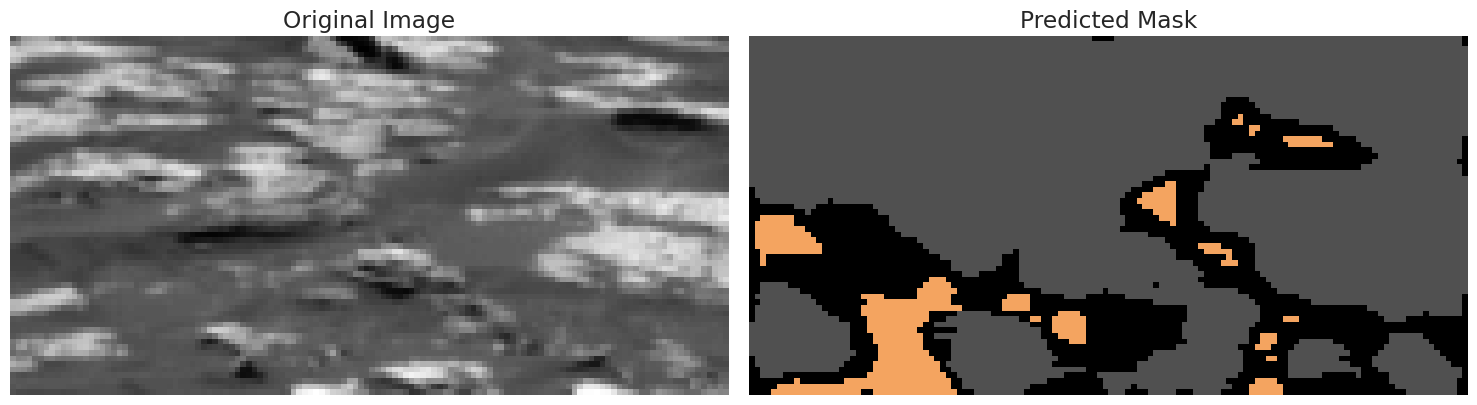

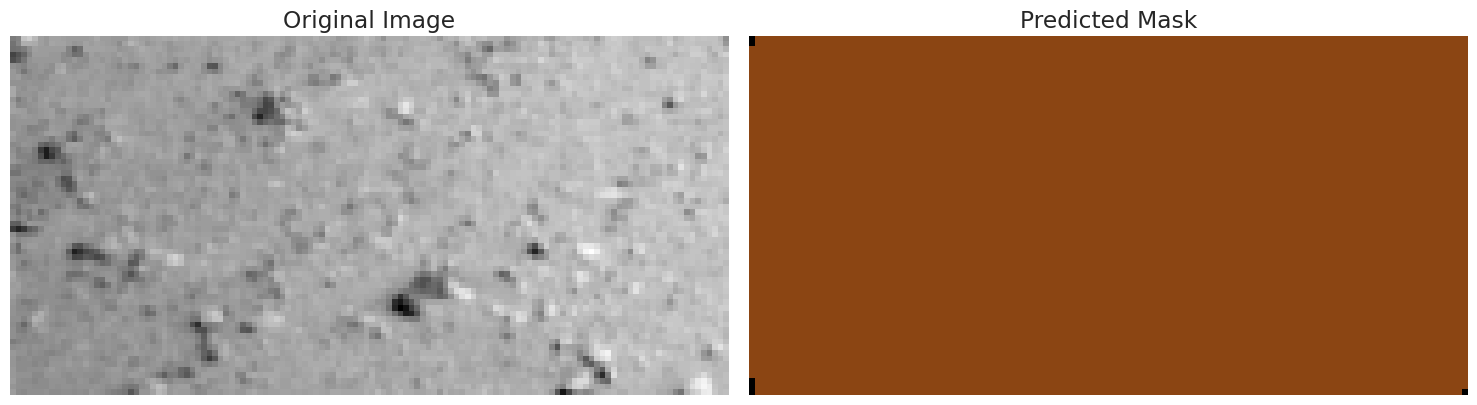

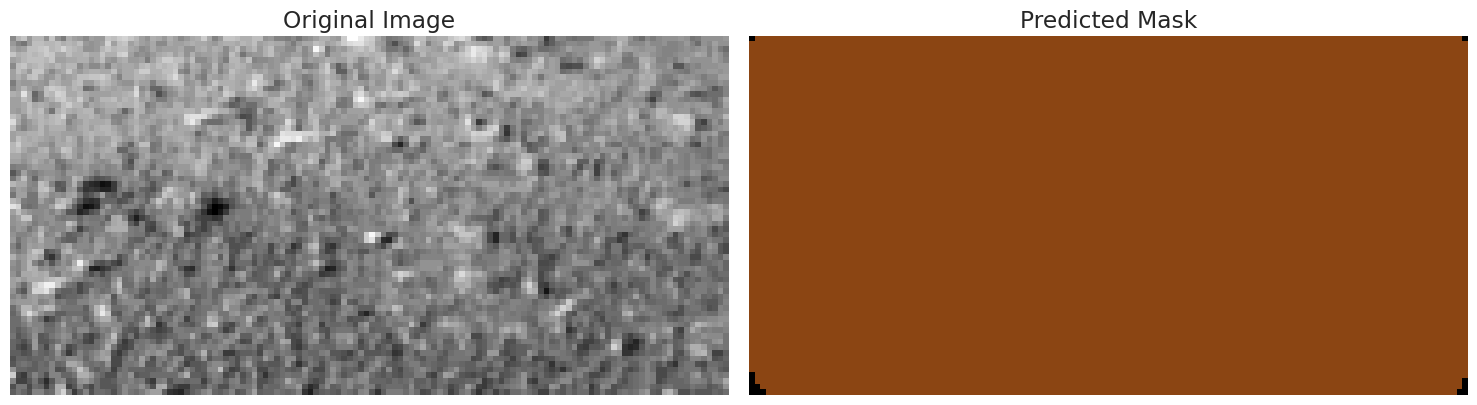

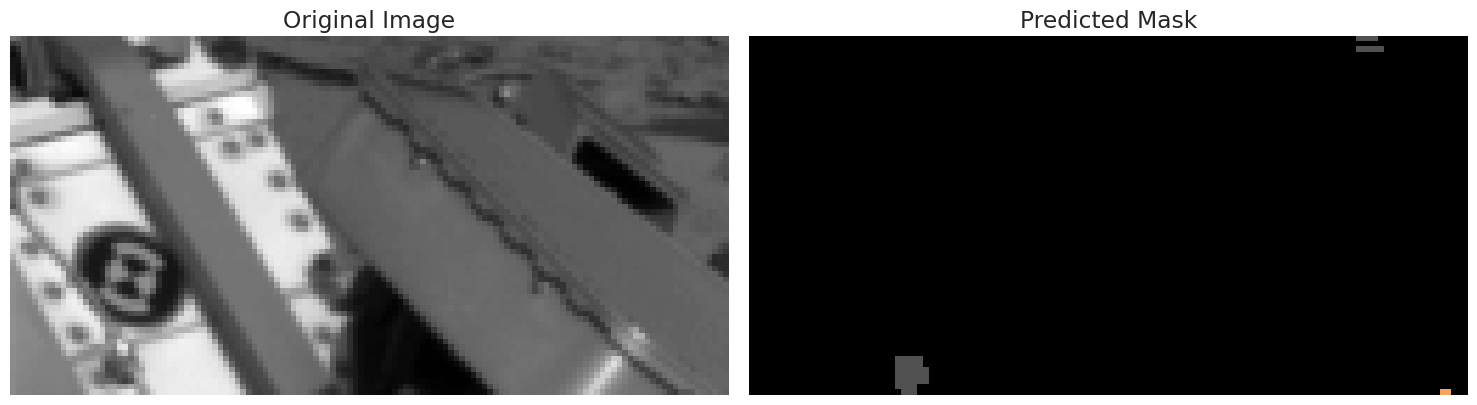

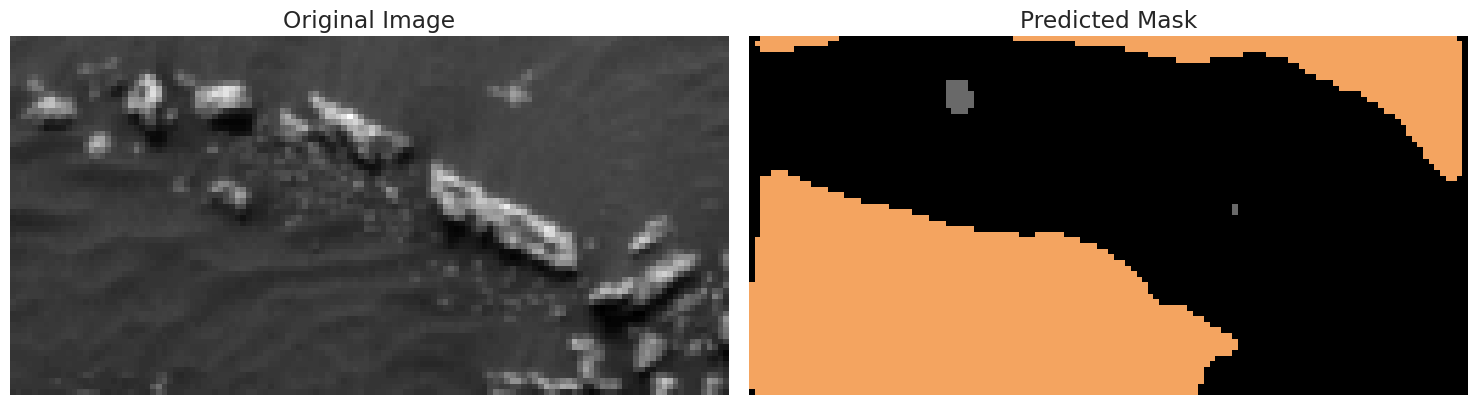

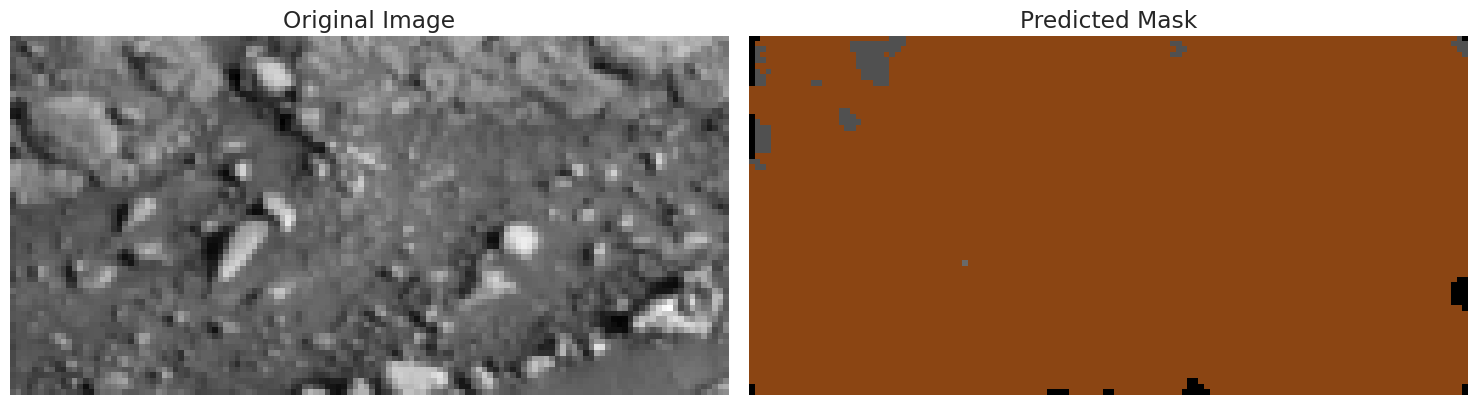

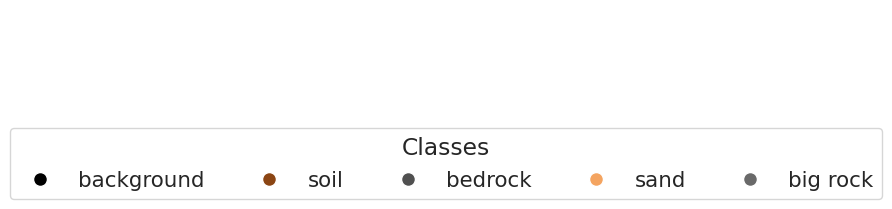

In [37]:
# Plot some predictions 
num_samples = 8
# Only take the first `num_samples` from X_test and preds
images = X_test[:num_samples]
predictions = preds[:num_samples]

# Adjust the number of classes to match the actual classes in the predictions (excluding 0)
num_classes = len(classes) # Excluding background

# Create a list to store the handles for the legend (only once)
handles = []

for i in range(num_samples):
    # Get the i-th image and its prediction
    image = images[i]
    predicted_mask = predictions[i]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot original image
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].set_title("Predicted Mask")
    colored_pred = apply_colormap(predicted_mask, colormap)
    axes[1].imshow(colored_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# After all images have been plotted, add the legend once
# We collect handles for the legend here, only once
for label_idx in category_map: 
    color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))

# Create a single legend displayed at the bottom
fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
ax.axis('off')
plt.show()

In [38]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [39]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)